In [1]:
#import helper_functions as helper
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper
print('Done')

Done


In [2]:
local_path = '/mnt/benshalom-nas/raw_data/irc_maxone_desktop/media/harddrive8tb/KCNT1_M1Plus_T1_01142025/KCNT1_M1Plus_T1_01142025/260206/P002820/Trace_20260206_16_09_54_250_mv_200micros.raw.h5'

In [4]:
import os

In [5]:

#local_path = '/home/benshalom/00-Assays+Recordings-00/StimPractice_20250616/VoltageStimEvokedAnalysis_20250806_LQR/VoltageStimEvokedAnal01_LQR_Max1+_P002851_K9_Cell01_Ch695_T01_200mv_400us_1p_1,2,5,10,20,50hz_Trace_20250806_14_10_35.raw.h5'
recording1 = se.read_maxwell(local_path,stream_id = 'well000')
freq_min = 300
freq_max = 4500


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

# --- Add file name ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

#print('Channel ids:', channel_ids)'
print(f'Local Path: {os.path.dirname(local_path)}/')
print(f'File: {file_name}')
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording1 = si.unsigned_to_signed(recording1)

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
# recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
# recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=25*fs)
recording_chunk = recording_bp.frame_slice(start_frame= 0*fs,end_frame=900*fs)

print(f"chunk duration: {recording_chunk.get_total_duration()} s")

The h5 compression library for Maxwell is already located in /home/mmp/hdf5_plugin_path_maxwell/libcompression.so!
Local Path: /mnt/benshalom-nas/raw_data/irc_maxone_desktop/media/harddrive8tb/KCNT1_M1Plus_T1_01142025/KCNT1_M1Plus_T1_01142025/260206/P002820/
File: Trace_20260206_16_09_54_250_mv_200micros.raw.h5
Sampling frequency: 20000.0
Number of channels: 502
Number of segments: 1
total_recording: 900.61 s
chunk duration: 900.0 s


In [6]:

recording_chunk.get_channel_ids()

array(['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22',
       '24', '26', '28', '30', '32', '34', '36', '38', '40', '42', '44',
       '46', '48', '50', '52', '54', '56', '58', '60', '62', '64', '66',
       '68', '70', '72', '74', '76', '78', '80', '82', '84', '86', '88',
       '90', '92', '94', '96', '98', '100', '102', '104', '106', '108',
       '110', '112', '114', '116', '118', '120', '122', '124', '126',
       '128', '130', '132', '134', '136', '138', '140', '142', '144',
       '146', '148', '150', '152', '154', '156', '158', '160', '162',
       '164', '166', '168', '170', '172', '174', '176', '178', '180',
       '182', '184', '186', '188', '190', '192', '194', '196', '198',
       '200', '202', '204', '206', '208', '210', '212', '214', '216',
       '218', '220', '222', '224', '226', '228', '230', '232', '234',
       '236', '238', '240', '242', '244', '246', '248', '250', '252',
       '254', '256', '258', '260', '262', '264', '266', '268', '270',
     

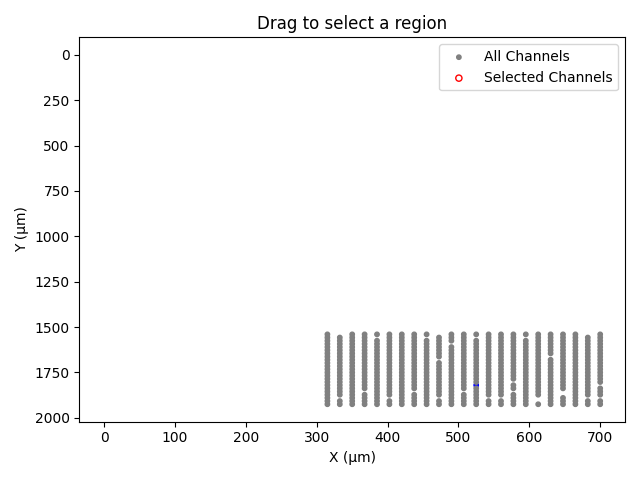

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os




%matplotlib widget
# Get channel coordinates
locs = recording_chunk.get_channel_locations()
channel_ids = recording_chunk.get_channel_ids()


channels_to_highlight = ['516']


# Setup figure
fig, ax = plt.subplots()
c = ['gray'] * len(channel_ids)  # Default color for all channels
for ch in channels_to_highlight: 
    if ch in channel_ids:
        idx = np.where(channel_ids == ch)[0][0]
        c[idx] = 'blue'  # Highlight specified channels in red   

sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Channels', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")

# Scatter for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Channels')
selected_channels = []

# Create an output widget for displaying messages
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_channels
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = channel_ids[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_channels = np.unique(np.concatenate((selected_channels, new_selection)))
    else:  # Overwrite selection
        selected_channels = new_selection

    selected_plot.set_offsets(locs[np.isin(channel_ids, selected_channels)])
    fig.canvas.draw_idle()
    #selected_channels = ",".join(map(str,selected_channels))
    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_channels)} channels")
        print(", ".join(f"'{s}'" for s in map(str, selected_channels.tolist())))
        #print(selected_channels)

# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Channels",
    button_style='success',
    tooltip='Save selected channel IDs to file'
)

# Define callback to save to file
def save_selected_channels_to_file(b):
    if len(selected_channels) == 0:
        with output:
            output.clear_output()
            print("No channels selected to save.")
        return

    save_path = "selected_channels.txt"
    with open(save_path, "w") as f:
        for ch in selected_channels:
            f.write(f"{ch}\n")

    with output:
        output.clear_output()
        print(f"Saved {len(selected_channels)} channel IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_channels_to_file)

# Display the save button and output widget
display(widgets.VBox([save_button, output]))
ax.invert_yaxis()  # Invert y-axis to match MEA layout

plt.legend()
plt.tight_layout()
plt.show()

# Importing custom helper functions from a specific path - LQRyan 2025-06-20 (TY MANDAR)
# This was helpful because the helper_functions.py file was not in the project folder I was using at the time.
import sys
sys.path.append('/home/benshalom/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis')
print('Listing Helper Functions Appended Paths:')
print (sys.path)
print('Done!')

In [17]:
"""Extract chip info from filename""" ## (LQRyan Naming Scheme for VoltStimArtAnalysis) - Mk03 - 20250729 
import os
import re
from datetime import datetime

def extract_chip_info_from_filename(file_path):
    """
    Extract chip type, chip ID, test number, voltage, date, and time from filename based on pattern: ChipType_ChipID_
    Also handles fallback extraction from parent directory names.
    
    Examples:
    - Max1_18706_T04_200mV_...Trace_20250718_15_52_59.raw.h5 -> returns ('Max1', '18706', 'T04', '200mV', '2025-07-18', '15:52:59')
    - Max1+_P002851_T03_120mV_...Trace_20250718_16_24_10.raw.h5 -> returns ('Max1+', 'P002851', 'T03', '120mV', '2025-07-18', '16:24:10')
    - Max2_M08035_T01_50mV_...Trace_20250718_12_30_22.raw.h5 -> returns ('Max2', 'M08035', 'T01', '50mV', '2025-07-18', '12:30:22')
    - Practice06(20mV(50+200+400us))Trace_20250707_14_20_24.raw.h5 -> returns (chip_type, chip_id, 'Practice_06', '20mV', '2025-07-07', '14:20:24')
    - CellsPractice_09(200mV_50,200,400us)Trace_20250716_10_55_06_0.raw.h5 -> returns (chip_type, chip_id, 'CellsPractice_09', '200mV', '2025-07-16', '10:55:06')
    """
    filename = os.path.basename(file_path)
    parent_dir = os.path.basename(os.path.dirname(file_path))
    
    ## Set variables
    chip_type = None
    chip_id = None
    expected_chip_type = None
    test_number = None
    voltage = None
    date_performed = None
    time_performed = None
    
    ## Extract date and time from filename
    ## Pattern: Trace_YYYYMMDD_HH_MM_SS.raw.h5 (original pattern)
    date_time_pattern = r'Trace_(\d{8})_(\d{2})_(\d{2})_(\d{2})\.raw\.h5'
    date_time_match = re.search(date_time_pattern, filename)
    
    if date_time_match:
        date_str = date_time_match.group(1)  # YYYYMMDD
        hour = date_time_match.group(2)
        minute = date_time_match.group(3)
        second = date_time_match.group(4)
        
        date_performed = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"  ## Format date as YYYY-MM-DD
        time_performed = f"{hour}:{minute}:{second}"                        ## Format time as HH:MM:SS
    else:
        ## Fallback pattern: handle additional underscore or digit at the end
        ## Pattern: Trace_YYYYMMDD_HH_MM_SS_X.raw.h5 (where X is optional digit)
        # fallback_date_time_pattern = r'Trace_(\d{8})_(\d{2})_(\d{2})_(\d{2})(?:_\d+)?\.raw\.h5'
        fallback_date_time_pattern = r'Trace_(\d{8})_(\d{2})_(\d{2})_(\d{2})'
        fallback_date_time_match = re.search(fallback_date_time_pattern, filename)
        
        if fallback_date_time_match:
            date_str = fallback_date_time_match.group(1)  # YYYYMMDD
            hour = fallback_date_time_match.group(2)
            minute = fallback_date_time_match.group(3)
            second = fallback_date_time_match.group(4)
            
            date_performed = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"  ## Format date as YYYY-MM-DD
            time_performed = f"{hour}:{minute}:{second}"                        ## Format time as HH:MM:SS
    
    ## Extract test number from filename
    ## Pattern 1: T followed by 2 digits (e.g., T03, T04) - ORIGINAL
    test_pattern = r'T(\d{2})'
    test_match = re.search(test_pattern, filename)
    
    if test_match:
        test_number = f"T{test_match.group(1)}"
    else:
        ## Pattern 2: Practice followed by 2 digits (e.g., Practice06, Practice15) - ORIGINAL
        practice_pattern = r'Practice(\d{2})'
        practice_match = re.search(practice_pattern, filename)
        
        if practice_match:
            test_number = f"Practice_{practice_match.group(1)}"
        else:
            ## NEW Pattern 3: CellsPractice followed by underscore and 2 digits (e.g., CellsPractice_09)
            cells_practice_pattern = r'CellsPractice_(\d{2})'
            cells_practice_match = re.search(cells_practice_pattern, filename)
            
            if cells_practice_match:
                test_number = f"CellsPractice_{cells_practice_match.group(1)}"
            else:
                test_number = "⚠️ Check Notes or Filename"
    
    ## Extract voltage from filename
    ## Pattern: 2-4 digits followed by mV (e.g., 50mV, 120mV, 200mV) - ORIGINAL
    voltage_pattern = r'(\d{2,4})mV'
    voltage_match = re.search(voltage_pattern, filename)
    
    if voltage_match:
        voltage = f"{voltage_match.group(1)}"
    else:
        voltage = "⚠️ Check Notes or Filename"
    
    ## Primary extraction: Look for chip type and ID in filename - ORIGINAL
    ## Pattern to match chip types followed by chip ID
    pattern = r'(Max(?:1\+?|2))_([^_]+)_'
    match = re.search(pattern, filename)
    
    if match:
        chip_type = match.group(1)
        chip_id = match.group(2)
        ## Remove "Chip" prefix if present (case-insensitive)
        chip_id = re.sub(r'^Chip', '', chip_id, flags=re.IGNORECASE)
    
    ## Fallback extraction: Look in parent folder - ENHANCED
    if not chip_type or not chip_id:
        parent_chip_pattern = r'(Max(?:1\+?|2))'                   ## Look for chip type in parent folder name
        parent_match = re.search(parent_chip_pattern, parent_dir)
        
        if parent_match and not chip_type:
            chip_type = parent_match.group(1)
        
        ## Look for chip ID patterns in parent directory - ENHANCED
        if not chip_id:
            # Pattern 1: 5 digits (e.g., 25183)
            if re.match(r'^\d{5}$', parent_dir):
                chip_id = parent_dir
            # Pattern 2: 7 characters starting with P followed by 6 digits (e.g., P002779, P123456)
            elif re.match(r'^P\d{6}$', parent_dir):
                chip_id = parent_dir
            # Pattern 3: 6 characters starting with M followed by 5 digits (e.g., M08035)
            elif re.match(r'^M\d{5}$', parent_dir):
                chip_id = parent_dir
            # NEW Pattern 4: Look for "Chip" followed by 5 digits in parent folder (e.g., Chip16461)
            elif re.match(r'^Chip\d{5}$', parent_dir):
                chip_id = re.sub(r'^Chip', '', parent_dir)  # Remove "Chip" prefix, keep just the numbers
            # NEW Pattern 5: Extract chip ID from complex parent folder name (e.g., StimTest_Max1_Chip16461_...)
            else:
                # Look for Max chip patterns in parent folder
                parent_chip_id_pattern = r'(Max(?:1\+?|2))_([^_]+)_'
                parent_chip_match = re.search(parent_chip_id_pattern, parent_dir)
                if parent_chip_match:
                    if not chip_type:
                        chip_type = parent_chip_match.group(1)
                    chip_id = parent_chip_match.group(2)
                    # Remove "Chip" prefix if present
                    chip_id = re.sub(r'^Chip', '', chip_id, flags=re.IGNORECASE)
                else:
                    # Look for standalone chip patterns in parent folder
                    chip_patterns = [
                        r'Chip(\d{5})',  # Chip followed by 5 digits
                        r'(P\d{6})',     # P followed by 6 digits
                        r'(M\d{5})',     # M followed by 5 digits
                        r'^(\d{5})$'     # Just 5 digits
                    ]
                    
                    for pattern in chip_patterns:
                        chip_match = re.search(pattern, parent_dir)
                        if chip_match:
                            chip_id = chip_match.group(1)
                            break
    
    ## Final chip ID handling if still not found - NEW
    if not chip_id:
        # Ask for user input
        user_input = input(f"⚠️  Chip ID not found in filename or folder. Please enter chip ID (or press Enter to use folder name '{parent_dir}'): ").strip()
        if user_input:
            chip_id = user_input
        else:
            chip_id = parent_dir
            print(f"⚠️  Warning: Using folder name '{parent_dir}' as chip ID. Please check your notes for the correct chip ID.")
    
    ## Determine expected chip type based on chip ID pattern - ORIGINAL
    if chip_id:
        if re.match(r'^\d+$', chip_id):  # Only numbers
            expected_chip_type = 'Max1'
        elif chip_id.startswith('P'):
            expected_chip_type = 'Max1+'
        elif chip_id.startswith('M'):
            expected_chip_type = 'Max2'
    
    ## Handle cases where chip type wasn't found but expected type was determined - ORIGINAL
    if not chip_type and expected_chip_type:
        chip_type = expected_chip_type
        print("⚠️  Chip type not found in filename or folder name.")
        print(f"Using expected chip type based on chip ID pattern: {expected_chip_type}")
    
    ## Check for conflicts between found chip type and expected chip type - ORIGINAL
    if chip_type and expected_chip_type:
        if chip_type == expected_chip_type:
            print("✅ No chip type conflicts! Chip type should be correct!")
        else:
            print("❌ Conflicting chip type information! Check your notes.")
            print(f"   Found chip type: {chip_type}")
            print(f"   Expected chip type based on ID pattern: {expected_chip_type}")
    
    ## Final fallback if still no chip info found - ORIGINAL
    if not chip_type:
        chip_type = '⚠️ Unknown'
    if not chip_id:
        chip_id = parent_dir
    
    return chip_type, chip_id, test_number, voltage, date_performed, time_performed

# Extract chip info from current file
chip_type, chip_id, test_number, voltage, date_performed, time_performed = extract_chip_info_from_filename(local_path)

print("=" * 50)
print("CHIP INFORMATION EXTRACTED:")
print("=" * 50)
print(f"Chip Type: {chip_type}")
print(f"Chip ID: {chip_id}")
print(f"Test Number: {test_number}")
print(f"Voltage: {voltage}mV")
if date_performed:
    print(f"Date Performed: {date_performed}")
else:
    print("Date Performed: ⚠️ Not found")
if time_performed:
    print(f"Time Performed: {time_performed}")
else:
    print("Time Performed: ⚠️ Not found")
print("=" * 50)

✅ No chip type conflicts! Chip type should be correct!
CHIP INFORMATION EXTRACTED:
Chip Type: Max1
Chip ID: 16461
Test Number: ⚠️ Check Notes or Filename
Voltage: ⚠️ Check Notes or FilenamemV
Date Performed: 2025-07-17
Time Performed: 13:41:13


In [18]:
"""EXPERIMENT DEFINITIONS - Define once, use everywhere""" # LQRyan 2025-08-04
# This cell should be run first to set experimental parameters

# =============================================================================
"""CHIP AND EXPERIMENT INFO (auto-extracted from filename)"""
# =============================================================================
# These are automatically extracted by the extract_chip_info_from_filename function
# chip_type, chip_id, test_number, voltage, date_performed, time_performed

# Extract channel IDs and 2D location coordinates 
channel_ids =np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()
# channels_to_highlight = [102]  # Channels to highlight

# =============================================================================
"""STIMULATION PARAMETERS"""
# =============================================================================
# Define stimulation channel ID (as string)
# stim_channel_id = '102'  # must be string  -- Practice 2,3,4,5
# stim_channel_id = '941'  # must be string  -- 6 well .... why does channel 593 look the same???
# stim_channel_id = '149'  # must be string  --  Max1+ Chip P002800 practice 11-15
#stim_channel_id = '272'  # (cellsPractice6-8)
# stim_channel_id = '190' # (cellsPractice1-5)
stim_channel_id = '554'
# stim_channel_id = '105'
#stim_channel_id = '149' # Max1+ Chip P002779 practice 06-19
#stim_channel_id = '#'
# =============================================================================
"""PULSE GROUPINGS AND PULSE WIDTHS"""
# =============================================================================
# Define pulse groupings based on pulse width
# Define pulse groupings (EDIT THIS FOR EACH EXPERIMENT) -- 
# This is for the titles of graphics, like the heatmaps I was making

# pulse_groupings = {
#     "Pulses 1-5 (50µs)": list(range(1, 6)),
#     "Pulses 6-10 (100µs)": list(range(6, 11)),
#     "Pulses 11-15 (200µs)": list(range(11, 16)),
#     "Pulses 16-20 (400µs)": list(range(16, 21))
# }
# pulse_groupings = {
#     "Pulses 1-5 (50µs)": list(range(1, 6)),
#     "Pulses 6-10 (200µs)": list(range(6, 11)),
#     "Pulses 11-15 (400µs)": list(range(11, 16))
# }
#manually define the pulses as the experiment involves pulses of different widths this is for pulse widths
pulse_groupings = {
    "Pulses 1-5 (50µs)": [1, 2, 3, 4, 5],
    "Pulses 6-10 (200µs)": [6, 7, 8, 9, 10],
    "Pulses 11-15 (400µs)": [11, 12, 13, 14, 15]
}

# ------------------------------------------------------------------
# --- Define pulse width mapping (EDIT THIS FOR EACH EXPERIMENT) --- 
# This is for the actual data collected - (dataframes, spreadsheets...)
# The 'restructured' dataframe will group pulses based on this and create a collumn for the pulse width of each pulse
# This can be reworked for any kind of variable - the variable that was changing within most of my recordings was pulse width.

# pulse_width_mapping = {
#     range(1, 6): 50,    # Pulses 1-5: 50µs
#     range(6, 11): 100,  # Pulses 6-10: 100µs
#     range(11, 16): 200, # Pulses 11-15: 200µs
#     range(16, 21): 400  # Pulses 16-20: 400µs
# }
pulse_width_mapping = {
    range(1, 6): "50µs",    # Pulses 1-5: 50µs
    range(6, 11): "200µs",  # Pulses 6-10: 200µs  
    range(11, 16): "400µs" # Pulses 11-15: 400µs
}

# =============================================================================
"""FILE PATHS AND DIRECTORIES"""
# =============================================================================

# Base directory for saving PNG figures - 

"""Artifact Analysis"""
# base_dir = "/home/benshalom/00-Images-00/VoltageStimArtAnalysis_Media_20250718_LQR" #the path I was using for Artifact Analysis

"""Evoked AP Analysis"""
base_dir = "/home/benshalom/00-Images-00/VoltageStimEvokedAnalysis_20250804" #the path I was using for my tests with Evoked AP Analysis - didn't finish as of 20250808

#----------------------------------------------------------------------
# Create output directory structure based on extracted chip information
output_dir = os.path.join(base_dir, chip_type, chip_id, test_number)
os.makedirs(output_dir, exist_ok=True)

# File path for excluded channels (from interactive selector) # can create a text file to exclude channels if you know this ahead of time - if a file is not detected it defaults to the stim channel
exclude_path = "selected_channels.txt"

# Base directory for saving Excel/data files - remember it's the appended path bc we use docker!
save_directory = "/home/benshalom/AnalysisResults"

# =============================================================================
"""ANALYSIS PARAMETERS"""
# =============================================================================
# Peak detection parameters for Artifacts
min_prominence = 10  # µV, adjust as needed -- Only peaks that "stick out" by at least this much above the surrounding valleys are considered.
min_height = 19.5     # µV, adjust as needed -- Only peaks with a value greater than or equal to this threshold are considered.

# Artifact detection window around each 'pulse_time_sec' - which for best results should match the artifact valley times in the stimulation channel
pre_ms = 4           # milliseconds before pulse
post_ms = 5          # milliseconds after pulse

# Peak 2 distance filtering -- you can adjust, but should be good for any stim (200mV, 400μs) or lower if set at 0.0005
max_peak2_valley_distance_s = 0.0005  # Maximum time between valley and Peak 2 (seconds) - if a peak is detected after this delay from the valley, it is likely not part of the artifact

# Valley delay filtering ranges --- This is basically a 'patch-clamp' solution I put in place to reduce the noise in my data for channels where the artifact is very close to or less than background noise
min_delay = -0.001   # minimum allowed valley delay (s)
max_delay = 0.002    # maximum allowed valley delay (s)

# =============================================================================
"""VISUALIZATION PARAMETERS"""
# =============================================================================
# Distance filtering for heatmaps -- If you have electrodes spanning across the entire chip, this canbe helpful to hone in your visual
max_distance_x = 200  # Maximum x distance in μm for heatmap filtering
max_distance_y = 200  # Maximum y distance in μm for heatmap filtering

# Axis buffer for plots - avoids cutting out data points on plots by having the bounds be just beyond the farthest data point desired
axis_buffer = 17.5   # Maximum extension beyond farthest points in μm 

# Debug window parameters for DetectPeaks function visualization + creating time window around artifact features to ignore while detecting APs
left_buffer = 0.00250          # seconds before the first feature - had set to 0.00045 previously, but we likely don't care about AP immediately before stimulation, so can be bigger... -LQRyan
right_buffer_valley = 0.00045  # -reccomend about 0.00045- seconds after valley if it's the last feature - a little bit longer than if after a peak, to account for wider valleys especially at low voltage, high pulse width
right_buffer_peak = 0.0003     # -reccomend about 0.0003 - seconds after peak if it's the last feature 

# =============================================================================
"""HELPER FUNCTIONS""" # These are called upon later for graphics and dataframes
# =============================================================================
def get_exclude_channels():
    """Get list of excluded channels from file or use default"""
    if os.path.exists(exclude_path):
        with open(exclude_path, "r") as f:
            return [line.strip() for line in f.readlines()]
    else:
        return [stim_channel_id]  # Exclude stim channel by default

def setup_output_directory(chip_type, chip_id, test_number):
    """Create and return output directory path with figure counter"""
    import glob
    
    output_dir = os.path.join(base_dir, chip_type, chip_id, test_number)
    os.makedirs(output_dir, exist_ok=True)
    
    # Find the next available figure number
    existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
    if existing_figures:
        existing_numbers = []
        for fig_path in existing_figures:
            filename = os.path.basename(fig_path)
            try:
                number_str = filename.split('_')[1].split('.')[0]
                existing_numbers.append(int(number_str))
            except (IndexError, ValueError):
                continue
        figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
    else:
        figure_counter = 1
    
    return output_dir, figure_counter

def get_pulse_width(pulse_number):
    """Get pulse width string for a given pulse number"""
    for pulse_range, width in pulse_width_mapping.items():
        if pulse_number in pulse_range:
            return width
    return "Unknown pulse width!"

# =============================================================================
"""PRINT CONFIGURATION SUMMARY"""
# =============================================================================
print("="*80)
print("EXPERIMENT CONFIGURATION LOADED")
print("="*80)
print(f"Stimulation Channel: {stim_channel_id}")
print(f"Pulse Groups: {len(pulse_groupings)} groups defined")
for label, pulses in pulse_groupings.items():
    print(f"  - {label}: pulses {pulses}")
print(f"Peak Detection: prominence ≥{min_prominence}µV, height ≥{min_height}µV")
print(f"Analysis Window: -{pre_ms}ms to +{post_ms}ms around each pulse")
print(f"Valley Delay Range: {min_delay}s to {max_delay}s")
print(f"Heatmap Distance Filter: ±{max_distance_x}×{max_distance_y}µm")
print(f"Base Output Directory: {base_dir}")
print(f"Output Directory: {output_dir}")
print("="*80)
# print(channel_ids)

EXPERIMENT CONFIGURATION LOADED
Stimulation Channel: 554
Pulse Groups: 3 groups defined
  - Pulses 1-5 (50µs): pulses [1, 2, 3, 4, 5]
  - Pulses 6-10 (200µs): pulses [6, 7, 8, 9, 10]
  - Pulses 11-15 (400µs): pulses [11, 12, 13, 14, 15]
Peak Detection: prominence ≥10µV, height ≥19.5µV
Analysis Window: -4ms to +5ms around each pulse
Valley Delay Range: -0.001s to 0.002s
Heatmap Distance Filter: ±200×200µm
Base Output Directory: /home/benshalom/00-Images-00/VoltageStimEvokedAnalysis_20250804
Output Directory: /home/benshalom/00-Images-00/VoltageStimEvokedAnalysis_20250804/Max1/16461/⚠️ Check Notes or Filename


In [11]:
##SCRATCH PAPER FOR GETTING CHANNELS AS STRINGS
scratch_channels = [17, 31, 41, 53, 87, 149, 505, 652, 655, 793, 845, 848, 901, 933, 1013]
scratch_channels = [str(ch) for ch in scratch_channels]
scratch_channels.sort(key=int)
print("channel_ids=['" + "','".join(scratch_channels) + "'],")#

channel_ids=['17','31','41','53','87','149','505','652','655','793','845','848','901','933','1013'],


In [21]:
#Interact With Traces
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
%matplotlib widget

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

# Visualize the traces interactively   ## --- Values need to be strings!!!! ie: ['channel_#', 'channel_#, ...]
print("Visualizing traces interactively...")

print(f"File: {file_name}")

sw.plot_timeseries(
    recording_chunk,
    mode='line',
    # channel_ids=['66', '73', '102', '676', '711', '942', '955', '964', '968'], #for Practice02-05
    
    # channel_ids=['853', '854', '906', '929', '937', '941', '968', '971'], # for 6 well i think
    
    # channel_ids=['149', '901', '848', '933', '793', '31', '41', '53', '655'], #Max1+_Repeat_20250707/P002800/Practice  11-15
    # channel_ids=['149', '153', '997', '933', '644', '817', '1016'], #Max1+_Repeat_20250707/P002800/Practice  11-15
    
    #channel_ids=['272', '198', '326', '868', '917', '148', '164', '392', '404', '921', '444'], # StimTest_Max1_Chip16461_CDKL5-RSA+_Brain04_Plated20250703/CellsPractice_06... (cellsPractice6-9)
    # channel_ids=['190', '675', '807', '875', '975', '984', '996', '454', '658', '694', '778', '391', '663', '818', '859', '923', '946', '958', '959'], #(cellsPractice1-5)
    
    # channel_ids=['554', '22', '116', '568', '860', '414', '688', '838', '158', '430', '442'],
    # channel_ids=['46','105','997'], # VoltStimArtAnalysis stim channel

   # channel_ids=['55' ,'83', '554', '571' ,'710', '714', '726', '815','825', '826', '855','867' ,'873', '971', '979', '983'], #Max1+_Repeat_20250707/P002779/Practice 06-10
    #channel_ids =['38','312','516','770','798'],
    channel_ids=['312'],
    show_channel_ids=True,
    backend='ipywidgets'
)

Visualizing traces interactively...
File: Trace_20260206_16_09_54_250_mv_200micros.raw.h5


/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/widgets/widget_list.py:167: UserWarning: plot_timeseries() is now plot_traces()
  warnings.warn("plot_timeseries() is now plot_traces()")


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [14]:
# ===============================
# Peak detection with channel roles
# ===============================

from scipy.signal import find_peaks
import numpy as np

# -------------------------------
# User-defined channels
# -------------------------------
channel_ids = ['38','312','516','770','798']

# -------------------------------
# Channel roles
# -------------------------------
STIM_CHANNELS = {'516'}                  # stimulation channels
NEURAL_CHANNELS = set(channel_ids) - STIM_CHANNELS

# -------------------------------
# Detection parameters (µV, ms)
# -------------------------------
DEFAULT_THRESH_UV = 30
STIM_THRESH_UV = 300
STIM_REFRACTORY_MS = 3.0               # lockout for stim artifacts

# -------------------------------
# Sanity checks
# -------------------------------
if 'recording_chunk' not in globals():
    raise RuntimeError("recording_chunk is not defined.")
if 'fs' not in globals():
    raise RuntimeError("fs (sampling frequency) is not defined.")

available_ids = recording_chunk.get_channel_ids()
for ch in channel_ids:
    if ch not in available_ids:
        raise ValueError(f"Channel {ch} not found in recording.")

# -------------------------------
# Peak detection
# -------------------------------
peak_results = {}

for ch in channel_ids:

    is_stim = ch in STIM_CHANNELS

    min_height = STIM_THRESH_UV if is_stim else DEFAULT_THRESH_UV
    distance = (
        int(STIM_REFRACTORY_MS * 1e-3 * fs)
    )

    raw = recording_chunk.get_traces(
        channel_ids=[ch],
        return_scaled=True
    )

    trace = np.asarray(raw).squeeze()
    if trace.ndim != 1:
        raise RuntimeError(f"Channel {ch}: unexpected shape {trace.shape}")

    peaks, props = find_peaks(
        -trace,
        height=min_height,
        distance=distance
    )

    peak_results[ch] = {
        "kind": "stim" if is_stim else "neural",
        "peaks": peaks,
        "times_s": peaks / fs,
        "amplitudes_uV": trace[peaks],
        "threshold_uV": min_height,
        "properties": props
    }

    print(
        f"Channel {ch:>4} | "
        f"{peak_results[ch]['kind']:6s} | "
        f"{len(peaks):4d} peaks | "
        f"thr = {min_height} µV"
    )

/tmp/ipykernel_1788636/3847491631.py:53: DeprecationWarning: `return_scaled` is deprecated and will be removed in version 0.105.0. Use `return_in_uV` instead.
  raw = recording_chunk.get_traces(


Channel   38 | neural | 2736 peaks | thr = 30 µV
Channel  312 | neural | 3328 peaks | thr = 30 µV
Channel  516 | stim   |  300 peaks | thr = 300 µV
Channel  770 | neural | 2526 peaks | thr = 30 µV
Channel  798 | neural | 2947 peaks | thr = 30 µV


In [47]:
peak_results['751']

{'kind': 'stim',
 'peaks': array([ 3617860,  3619864,  3621868, ..., 12013063, 12015079, 12017095],
       shape=(2400,)),
 'times_s': array([180.893  , 180.9932 , 181.0934 , ..., 600.65315, 600.75395,
        600.85475], shape=(2400,)),
 'amplitudes_uV': array([-4475.212 , -4771.042 , -4745.8647, ..., -5337.5244, -5337.5244,
        -5337.5244], shape=(2400,), dtype=float32),
 'threshold_uV': 300,
 'properties': {'peak_heights': array([4475.21191406, 4771.04199219, 4745.86474609, ..., 5337.52441406,
         5337.52441406, 5337.52441406], shape=(2400,))}}

In [48]:
peak_results['1009']

{'kind': 'neural',
 'peaks': array([   63097,    65351,    71937, ..., 14046326, 14240081, 14242773],
       shape=(2926,)),
 'times_s': array([  3.15485,   3.26755,   3.59685, ..., 702.3163 , 712.00405,
        712.13865], shape=(2926,)),
 'amplitudes_uV': array([-50.354004, -37.765503, -31.471252, ..., -44.059753, -44.059753,
        -37.765503], shape=(2926,), dtype=float32),
 'threshold_uV': 30,
 'properties': {'peak_heights': array([50.35400391, 37.76550293, 31.47125244, ..., 44.05975342,
         44.05975342, 37.76550293], shape=(2926,))}}

In [33]:
# Cell 1 — prepare data for 180–340 s window
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# set channel id (change if needed)
ch = '312'

time_start = 720# seconds
time_end = 780# seconds
if 'peak_results' not in globals():
    raise RuntimeError("peak_results not found in notebook globals")

if ch not in peak_results:
    ch = list(peak_results.keys())[0]  # fallback to first channel
    print(f"Using channel {ch}")

data = peak_results[ch]

times = np.asarray(data['times_s'])
amps = np.asarray(data['amplitudes_uV'])
#get max amps in total
max_amp = np.max(np.abs(amps))
mask = (times >= time_start) & (times <= time_end)
times_win = times[mask]
amps_win = amps[mask]

print(f"Channel {ch}: {len(times_win)} events between {time_start} and {time_end} s")

Channel 312: 168 events between 720 and 780 s


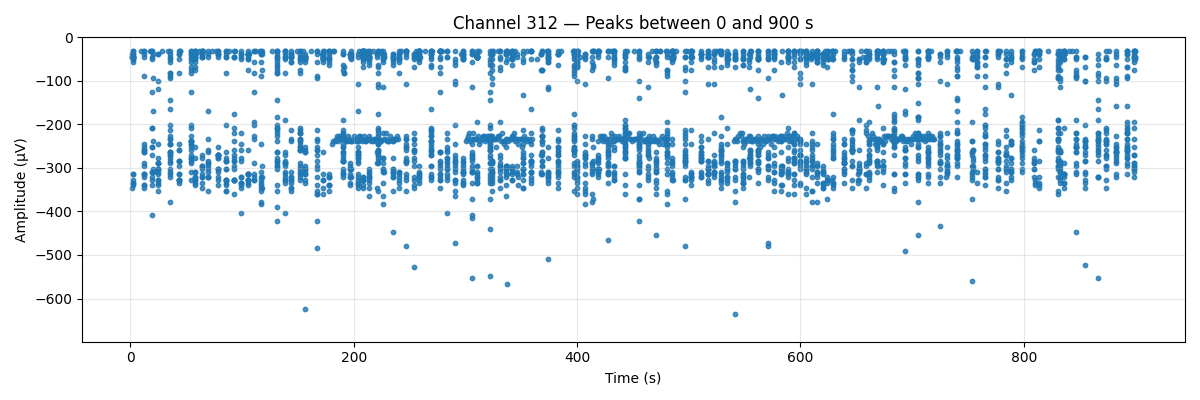

In [17]:
# Cell 2 — plot time (x) vs amplitude (y) for selected window
import matplotlib.pyplot as plt
# dont have lines connecting points

plt.figure(figsize=(12, 4))
plt.scatter(times_win, amps_win, s=10, c='tab:blue', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'Channel {ch} — Peaks between {time_start} and {time_end} s')
plt.grid(alpha=0.3)
plt.ylim(-max_amp * 1.1, 0)  # set y-limits based on max amplitude
plt.tight_layout()
plt.show()

In [43]:
!pip install spython

Defaulting to user installation because normal site-packages is not writeable


In [44]:
# Complete minimal spike sorting workflow for baseline and post-stimulation analysis
# Uses SpikeInterface with lightweight sorter (tridesclous)

import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre

# ============================================================================
# STEP 1: Define time windows and extract recording chunks
# ============================================================================
# Define your time windows (adjust based on your data)
baseline_start = 0      # seconds
baseline_end = 180      # seconds (before first stim)
post_stim_start = 481   # seconds (after last 400µs stim at ~480s)
post_stim_end = 660     # seconds (end of recording)

# Use your existing recording variable
if 'recording' not in globals():
    recording = recording_chunk  # use your existing variable name

# Get sampling frequency
fs = recording.get_sampling_frequency()

# Extract baseline chunk
baseline_frames_start = int(baseline_start * fs)
baseline_frames_end = int(baseline_end * fs)
rec_baseline = recording.frame_slice(
    start_frame=baseline_frames_start,
    end_frame=baseline_frames_end
)

# Extract post-stimulation chunk
post_stim_frames_start = int(post_stim_start * fs)
post_stim_frames_end = int(post_stim_end * fs)
rec_post_stim = recording.frame_slice(
    start_frame=post_stim_frames_start,
    end_frame=post_stim_frames_end
)

print(f"✓ Baseline recording: {rec_baseline.get_total_duration():.1f} s, {rec_baseline.get_num_channels()} channels")
print(f"✓ Post-stim recording: {rec_post_stim.get_total_duration():.1f} s, {rec_post_stim.get_num_channels()} channels")

# ============================================================================
# STEP 2: Preprocess recordings
# ============================================================================
def preprocess_for_sorting(recording):
    """Minimal preprocessing pipeline"""
    rec_filtered = spre.bandpass_filter(recording, freq_min=300, freq_max=6000)
    return rec_filtered

rec_baseline_filt = preprocess_for_sorting(rec_baseline)
rec_post_stim_filt = preprocess_for_sorting(rec_post_stim)
print("✓ Preprocessing complete")

# ============================================================================
# STEP 3: Run spike sorting on both periods
# ============================================================================
sorter_name = 'tridesclous'  # Fast and good for single/few channels

print("\n📊 Sorting baseline period...")
sorting_baseline = ss.run_sorter(
    sorter_name=sorter_name,
    recording=rec_baseline_filt,
    output_folder='./sorting_output/baseline',
    verbose=True,
    remove_existing_folder=True
)

print(f"\n✓ Baseline sorting complete: {len(sorting_baseline.get_unit_ids())} units found")
for unit_id in sorting_baseline.get_unit_ids():
    n_spikes = len(sorting_baseline.get_unit_spike_train(unit_id))
    spike_rate = n_spikes / rec_baseline.get_total_duration()
    print(f"  Unit {unit_id}: {n_spikes} spikes ({spike_rate:.2f} Hz)")

print("\n📊 Sorting post-stimulation period...")
sorting_post_stim = ss.run_sorter(
    sorter_name=sorter_name,
    recording=rec_post_stim_filt,
    output_folder='./sorting_output/post_stim',
    verbose=True,
    remove_existing_folder=True
)

print(f"\n✓ Post-stim sorting complete: {len(sorting_post_stim.get_unit_ids())} units found")
for unit_id in sorting_post_stim.get_unit_ids():
    n_spikes = len(sorting_post_stim.get_unit_spike_train(unit_id))
    spike_rate = n_spikes / rec_post_stim.get_total_duration()
    print(f"  Unit {unit_id}: {n_spikes} spikes ({spike_rate:.2f} Hz)")

# ============================================================================
# STEP 4: Extract and visualize results
# ============================================================================
def get_all_spike_times(sorting, recording):
    """Get spike times in seconds for all units"""
    fs = recording.get_sampling_frequency()
    all_times = []
    all_units = []
    
    for unit_id in sorting.get_unit_ids():
        spike_frames = sorting.get_unit_spike_train(unit_id)
        spike_times = spike_frames / fs
        all_times.extend(spike_times)
        all_units.extend([unit_id] * len(spike_times))
    
    return np.array(all_times), np.array(all_units)

times_baseline, units_baseline = get_all_spike_times(sorting_baseline, rec_baseline)
times_post_stim, units_post_stim = get_all_spike_times(sorting_post_stim, rec_post_stim)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))

# Baseline raster
for unit_id in np.unique(units_baseline):
    mask = units_baseline == unit_id
    ax1.scatter(times_baseline[mask], np.ones(np.sum(mask)) * unit_id, 
               s=2, alpha=0.7, label=f'Unit {unit_id}')
ax1.set_ylabel('Unit ID', fontsize=11)
ax1.set_title(f'Baseline Activity ({baseline_start}-{baseline_end} s) — Ch {ch}', 
             fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', markerscale=3)
ax1.grid(alpha=0.3)

# Post-stim raster
for unit_id in np.unique(units_post_stim):
    mask = units_post_stim == unit_id
    ax2.scatter(times_post_stim[mask], np.ones(np.sum(mask)) * unit_id,
               s=2, alpha=0.7, label=f'Unit {unit_id}')
ax2.set_xlabel('Time (s)', fontsize=11)
ax2.set_ylabel('Unit ID', fontsize=11)
ax2.set_title(f'Post-Stimulation Activity ({post_stim_start}-{post_stim_end} s) — Ch {ch}', 
             fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', markerscale=3)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 5: Summary statistics
# ============================================================================
print("\n" + "="*70)
print("SUMMARY: Baseline vs Post-Stimulation")
print("="*70)
print(f"Baseline period:        {baseline_start}-{baseline_end} s ({baseline_end - baseline_start} s)")
print(f"Post-stim period:       {post_stim_start}-{post_stim_end} s ({post_stim_end - post_stim_start} s)")
print(f"\nBaseline units:         {len(np.unique(units_baseline))}")
print(f"Post-stim units:        {len(np.unique(units_post_stim))}")
print(f"\nBaseline total spikes:  {len(times_baseline)}")
print(f"Post-stim total spikes: {len(times_post_stim)}")
print(f"\nBaseline firing rate:   {len(times_baseline)/rec_baseline.get_total_duration():.2f} Hz")
print(f"Post-stim firing rate:  {len(times_post_stim)/rec_post_stim.get_total_duration():.2f} Hz")

# Per-unit comparison
if len(sorting_baseline.get_unit_ids()) > 0:
    print(f"\nBaseline unit firing rates:")
    for unit_id in sorting_baseline.get_unit_ids():
        n_spikes = len(sorting_baseline.get_unit_spike_train(unit_id))
        rate = n_spikes / rec_baseline.get_total_duration()
        print(f"  Unit {unit_id}: {rate:.2f} Hz ({n_spikes} spikes)")

if len(sorting_post_stim.get_unit_ids()) > 0:
    print(f"\nPost-stim unit firing rates:")
    for unit_id in sorting_post_stim.get_unit_ids():
        n_spikes = len(sorting_post_stim.get_unit_spike_train(unit_id))
        rate = n_spikes / rec_post_stim.get_total_duration()
        print(f"  Unit {unit_id}: {rate:.2f} Hz ({n_spikes} spikes)")

print("="*70)
print("✅ Spike sorting analysis complete!")


✓ Baseline recording: 180.0 s, 472 channels
✓ Post-stim recording: 179.0 s, 472 channels
✓ Preprocessing complete

📊 Sorting baseline period...


Exception: The sorter tridesclous is not installed. Please install it with:

To use Tridesclous run:

       >>> pip install tridesclous

    More information on tridesclous at:
      * https://github.com/tridesclous/tridesclous
      * https://tridesclous.readthedocs.io
    

/tmp/ipykernel_2189918/511834874.py:77: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


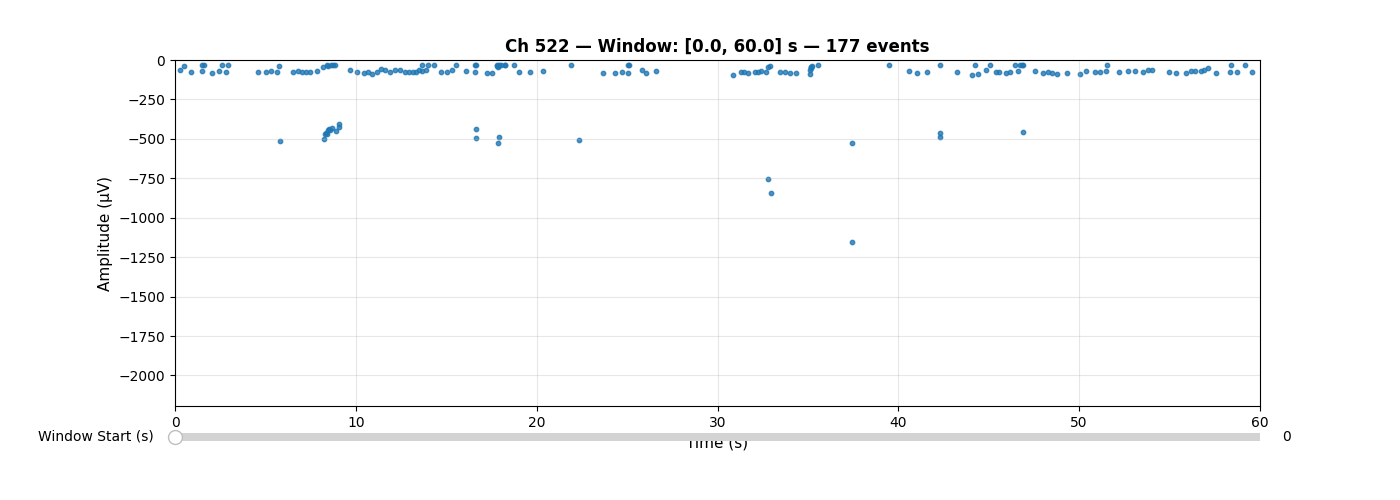

💡 Drag the slider to scroll the 60s window through 0-660s!
   Total range: 660 seconds
   Window size: 60 seconds (FIXED)
   Slider range: 0 to 600 seconds


In [39]:
# Cell 2 — Scrollable plot with FIXED 60s window using single Slider
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Fixed window size to display
WINDOW_SIZE = 60  # seconds (FIXED!)

# Calculate how far the window can slide
max_window_start = time_end - WINDOW_SIZE
if max_window_start < time_start:
    raise ValueError(f"Time range ({time_end - time_start}s) is smaller than window size ({WINDOW_SIZE}s)")

# Create figure with space for slider at bottom
fig = plt.figure(figsize=(14, 5))
ax_plot = plt.subplot2grid((20, 1), (0, 0), rowspan=18)
ax_slider = plt.subplot2grid((20, 1), (19, 0))

# Initial window position (start at beginning)
initial_window_start = time_start
initial_window_end = initial_window_start + WINDOW_SIZE

# Initial plot - only show events in first window
mask_initial = (times_win >= initial_window_start) & (times_win <= initial_window_end)
scatter = ax_plot.scatter(times_win[mask_initial], amps_win[mask_initial], 
                          s=10, c='tab:blue', alpha=0.8)

ax_plot.set_xlabel('Time (s)', fontsize=11)
ax_plot.set_ylabel('Amplitude (µV)', fontsize=11)
ax_plot.grid(alpha=0.3)
ax_plot.set_ylim(-max_amp * 1.1, 0)
ax_plot.set_xlim(initial_window_start, initial_window_end)

# Update title with event count
mask_count = mask_initial
n_events_initial = np.sum(mask_count)
ax_plot.set_title(
    f'Ch {ch} — Window: [{initial_window_start:.1f}, {initial_window_end:.1f}] s — {n_events_initial} events',
    fontsize=12, fontweight='bold'
)

# Create single Slider for window START position
slider = Slider(
    ax_slider,
    'Window Start (s)',
    time_start,                # min: earliest start position
    max_window_start,          # max: latest start position
    valinit=initial_window_start,
    valstep=1.0,              # 1 second steps
    color='steelblue'
)

# Update function when slider is moved
def update(val):
    window_start = slider.val
    window_end = window_start + WINDOW_SIZE  # FIXED 60s window!
    
    # Update x-axis limits (slide the window)
    ax_plot.set_xlim(window_start, window_end)
    
    # Update scatter plot to show only events in current window
    mask_current = (times_win >= window_start) & (times_win <= window_end)
    scatter.set_offsets(np.c_[times_win[mask_current], amps_win[mask_current]])
    
    # Update title with current window and event count
    n_events = np.sum(mask_current)
    ax_plot.set_title(
        f'Ch {ch} — Window: [{window_start:.1f}, {window_end:.1f}] s — {n_events} events',
        fontsize=12, fontweight='bold'
    )
    
    fig.canvas.draw_idle()

# Connect slider to update function
slider.on_changed(update)

plt.tight_layout()
plt.show()

print(f"💡 Drag the slider to scroll the {WINDOW_SIZE}s window through {time_start}-{time_end}s!")
print(f"   Total range: {time_end - time_start} seconds")
print(f"   Window size: {WINDOW_SIZE} seconds (FIXED)")
print(f"   Slider range: {time_start} to {max_window_start} seconds")


In [15]:
# ...existing code...
# New cell — save trace snapshot (time window) to PDF (multiple snapshots per page)

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ============================================================================
# Configuration and validation
# ============================================================================
if 'ch' not in globals():
    ch = '1009'
if 'time_start' not in globals() or 'time_end' not in globals():
    raise RuntimeError("time_start/time_end not defined")
if 'recording_chunk' not in globals() or 'fs' not in globals():
    raise RuntimeError("recording_chunk or fs not defined")
if 'chip_type' not in globals() or 'chip_id' not in globals():
    chip_type = "KCNT1_MAX!PLUS"
    chip_id = "UnknownChipID"

output_dir = "/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/StimulationAnalysis"

# Zoom parameters (±5 ms around each detected event)
zoom_ms = 5
zoom_s = zoom_ms / 1000.0

# Subplot grid configuration (adjust to preference)
plots_per_page = 12  # 4 rows × 3 columns = 12 snapshots per page
nrows = 4
ncols = 3

# ============================================================================
# Get event times
# ============================================================================
if 'times_win' in globals() and len(times_win) > 0:
    event_times = np.asarray(times_win)
    event_amps = np.asarray(amps_win) if 'amps_win' in globals() else None
else:
    if 'peak_results' in globals() and ch in peak_results:
        event_times = np.asarray(peak_results[ch]['times_s'])
        event_amps = np.asarray(peak_results[ch]['amplitudes_uV'])
        mask = (event_times >= time_start) & (event_times <= time_end)
        event_times = event_times[mask]
        if event_amps is not None:
            event_amps = event_amps[mask]
    else:
        raise RuntimeError("No events found in times_win or peak_results for channel")

if len(event_times) == 0:
    raise RuntimeError("No detected events inside the requested time window.")

print(f"📊 Generating snapshots for {len(event_times)} events...")
print(f"   Layout: {nrows}×{ncols} = {plots_per_page} plots per page")
print(f"   Total pages: {int(np.ceil(len(event_times) / plots_per_page))}")

# ============================================================================
# Prepare output
# ============================================================================
os.makedirs(output_dir, exist_ok=True)
pdf_fname = f'{chip_type}_{chip_id}_Ch{ch}_{int(time_start)}-{int(time_end)}s_snapshots_{zoom_ms}ms.pdf'
pdf_path = os.path.join(output_dir, pdf_fname)

# Get total recording duration
try:
    total_duration = recording_chunk.get_total_duration()
    total_frames = int(total_duration * fs)
except AttributeError:
    total_frames = recording_chunk.get_num_samples()

# ============================================================================
# Generate PDF with multiple snapshots per page
# ============================================================================
with PdfPages(pdf_path) as pdf:
    num_pages = int(np.ceil(len(event_times) / plots_per_page))
    
    for page_num in range(num_pages):
        # Determine which events go on this page
        start_idx = page_num * plots_per_page
        end_idx = min(start_idx + plots_per_page, len(event_times))
        events_this_page = end_idx - start_idx
        
        # Create figure with subplots
        fig, axes = plt.subplots(
            nrows=nrows, 
            ncols=ncols, 
            figsize=(11, 14),  # Letter size portrait
            dpi=100
        )
        axes = axes.flatten()  # Convert to 1D array for easy indexing
        
        # Add overall title for the page
        fig.suptitle(
            f'{chip_type} {chip_id} — Channel {ch} — Page {page_num + 1}/{num_pages}',
            fontsize=14,
            fontweight='bold',
            y=0.995
        )
        
        # Plot each event on this page
        for subplot_idx in range(plots_per_page):
            ax = axes[subplot_idx]
            event_idx = start_idx + subplot_idx
            
            # If we've run out of events, hide remaining subplots
            if event_idx >= len(event_times):
                ax.set_visible(False)
                continue
            
            t_event = event_times[event_idx]
            
            # Calculate frame indices
            center_frame = int(t_event * fs)
            frames_offset = int(zoom_s * fs)
            start_frame = max(0, center_frame - frames_offset)
            end_frame = min(total_frames, center_frame + frames_offset)
            
            # Fetch trace data
            try:
                traces = recording_chunk.get_traces(
                    start_frame=start_frame,
                    end_frame=end_frame,
                    channel_ids=[ch],
                    return_scaled=True
                )
                trace = traces.squeeze()
            except Exception as e:
                ax.text(0.5, 0.5, f'Error loading\nevent {event_idx + 1}',
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=8, color='red')
                continue
            
            # Time axis in milliseconds, centered on event
            actual_frames = len(trace)
            frame_indices = np.arange(start_frame, start_frame + actual_frames)
            time_axis = (frame_indices / fs - t_event) * 1000  # Convert to ms
            
            # Plot trace
            ax.plot(time_axis, trace, color='black', linewidth=0.6, rasterized=True)
            ax.axvline(0.0, color='red', linestyle='--', lw=0.8, alpha=0.7)
            
            # Mark peak amplitude if available
            if event_amps is not None and event_idx < len(event_amps):
                ax.plot(0.0, event_amps[event_idx], 'ro', markersize=4)
            
            # Formatting
            ax.set_xlim(-zoom_ms, zoom_ms)
            ax.set_xlabel('Time (ms)', fontsize=7)
            ax.set_ylabel('Amp (µV)', fontsize=7)
            ax.tick_params(labelsize=6)
            ax.grid(alpha=0.2, linestyle=':', linewidth=0.4)
            
            # Title with event number and time
            title = f'Event {event_idx + 1}: {t_event:.4f} s'
            if event_amps is not None and event_idx < len(event_amps):
                title += f'\n{event_amps[event_idx]:.1f} µV'
            ax.set_title(title, fontsize=7, pad=3)
        
        # Adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.99])
        
        # Save page to PDF
        pdf.savefig(fig, bbox_inches='tight', dpi=100)
        plt.close(fig)
        
        print(f"  ✓ Page {page_num + 1}/{num_pages} complete ({events_this_page} events)")

print(f"\n✅ Saved ALL {len(event_times)} snapshots (±{zoom_ms} ms) to:")
print(f"   {pdf_path}")
print(f"   File size: {os.path.getsize(pdf_path) / 1e6:.2f} MB")
print(f"   Pages: {num_pages} ({plots_per_page} plots/page)")
# ...existing code...


📊 Generating snapshots for 730 events...
   Layout: 4×3 = 12 plots per page
   Total pages: 61


/tmp/ipykernel_2189918/1315741255.py:120: DeprecationWarning: `return_scaled` is deprecated and will be removed in version 0.105.0. Use `return_in_uV` instead.
  traces = recording_chunk.get_traces(


  ✓ Page 1/61 complete (12 events)
  ✓ Page 2/61 complete (12 events)
  ✓ Page 3/61 complete (12 events)
  ✓ Page 4/61 complete (12 events)
  ✓ Page 5/61 complete (12 events)
  ✓ Page 6/61 complete (12 events)
  ✓ Page 7/61 complete (12 events)
  ✓ Page 8/61 complete (12 events)
  ✓ Page 9/61 complete (12 events)
  ✓ Page 10/61 complete (12 events)
  ✓ Page 11/61 complete (12 events)
  ✓ Page 12/61 complete (12 events)
  ✓ Page 13/61 complete (12 events)
  ✓ Page 14/61 complete (12 events)
  ✓ Page 15/61 complete (12 events)
  ✓ Page 16/61 complete (12 events)
  ✓ Page 17/61 complete (12 events)
  ✓ Page 18/61 complete (12 events)
  ✓ Page 19/61 complete (12 events)
  ✓ Page 20/61 complete (12 events)
  ✓ Page 21/61 complete (12 events)
  ✓ Page 22/61 complete (12 events)
  ✓ Page 23/61 complete (12 events)
  ✓ Page 24/61 complete (12 events)
  ✓ Page 25/61 complete (12 events)
  ✓ Page 26/61 complete (12 events)
  ✓ Page 27/61 complete (12 events)
  ✓ Page 28/61 complete (12 events)
 

In [16]:
"""Artifact detection and Analysis Mk_09 -cut down a bit """ ## -LQRyan 2025-07-30
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from scipy.signal import find_peaks
from IPython.display import display
import os

# Get basic recording metadata
channel_ids = recording_chunk.get_channel_ids()
#print(channel_ids)

fs = recording_chunk.get_sampling_frequency()
locations = recording_chunk.get_channel_locations()  # shape = (N_channels, 2)
num_chan = recording_chunk.get_num_channels()

# Create spatial metadata table
channel_df = pd.DataFrame({
    'channel_id': channel_ids,
    'x': locations[:, 0],
    'y': locations[:, 1]
})

##################################################################
# trig for distance from stim calculations
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]
channel_df['distance_to_stim'] = np.sqrt((channel_df['x'] - stim_x) ** 2 + (channel_df['y'] - stim_y) ** 2)

# --- Artifact feature extraction --- 
"""PULSE WINDOWS MOVED TO ITS OWN CELL, ABOVE"""

################################################################

# Window length around each pulse (±5ms → 10ms window) # moved to definitions cell
pre_samples = int((pre_ms / 1000) * fs)
post_samples = int((post_ms / 1000) * fs)

# --- Peak 2 distance filtering parameters ---
max_peak2_valley_distance_s = 0.0005  # Maximum allowed time between valley and Peak 2 (in seconds)
                                      # Adjust this value based on your data - peaks beyond this will be set to NaN
max_peak2_valley_distance_samples = int(max_peak2_valley_distance_s * fs)

all_pulse_data = []

for pulse_time in pulse_times_sec:
    center = int(pulse_time * fs)
    start = center - pre_samples
    end = center + post_samples
    # Get scaled data in μV 
    trace = recording_chunk.get_traces(start_frame=start, end_frame=end, return_scaled=True)  # (n_samples, n_channels)
    
    # FIXED: Calculate stim valley time for THIS specific pulse
    stim_valley_time = None
    if stim_channel_id in channel_ids:
        stim_ch_idx = np.where(channel_ids == stim_channel_id)[0][0]
        stim_waveform = trace[:, stim_ch_idx]
        stim_times = np.arange(start, end) / fs
        
        # Find valley in stimulation channel for this pulse
        min_prominence = 10  # µV, adjust as needed
        min_height = 19.5     # µV, adjust as needed
        
        stim_valley_indices, stim_valley_props = find_peaks(
            -stim_waveform,
            prominence=min_prominence,
            height=min_height
        )
        
        if len(stim_valley_indices) > 0:
            stim_valley_amplitudes = stim_waveform[stim_valley_indices]
            stim_lowest_valley_idx = np.argmin(stim_valley_amplitudes)
            stim_best_valley = stim_valley_indices[stim_lowest_valley_idx]
            stim_valley_time = stim_times[stim_best_valley]
    
    #print(trace.shape)
    
    for ch_idx, ch_id in enumerate(channel_ids):
        #print(ch_idx, ch_id)
        waveform = trace[:, ch_idx]   # μV to mV   ????????????????????????
        
        #print(max(waveform), min(waveform))
        # Absolute time for each sample in the window
        times = np.arange(start, end) / fs  # absolute time in seconds

        # Tune these parameters for your data
        
        """
        # waveform: your signal for one channel
        mad = np.median(np.abs(waveform - np.median(waveform)))
        if mad == 0:
            noise_std = 2.0  # or another small constant, e.g., np.std(waveform)
        else:
            noise_std = mad / 0.6745

        # Set thresholds as multiples of noise -------------------------------------------------------------------
        min_height = 4 * noise_std
        min_prominence = 4 * noise_std
        """
        
        # --- Find valleys first ---
        valley_indices, valley_props = find_peaks(
            -waveform,
            prominence=min_prominence,
            height=min_height
        )

        # --- Select the lowest valley (by amplitude, i.e., most negative value) ---
        if len(valley_indices) > 0:
            valley_amplitudes = waveform[valley_indices]
            lowest_valley_idx = np.argmin(valley_amplitudes)
            best_valley = valley_indices[lowest_valley_idx]
            valley_time_idx = best_valley  # Store the time index of the valley
        else:
            best_valley = None
            valley_time_idx = None

        # --- MODIFIED: Different peak detection based on valley presence ---
        best_peaks = []
        
        if valley_time_idx is not None:
            # ORIGINAL LOGIC: Valley detected - find peaks with original thresholds
            peak_indices, peak_props = find_peaks(
                waveform,
                prominence=min_prominence,
                height=min_height
            )
            
            if len(peak_indices) > 0:
                # Find peaks before the valley
                peaks_before = peak_indices[peak_indices < valley_time_idx]
                if len(peaks_before) > 0:
                    peak1_amplitudes = waveform[peaks_before]
                    highest_before_idx = np.argmax(peak1_amplitudes)
                    peak1 = peaks_before[highest_before_idx]
                    best_peaks.append(peak1)
                
                # Find peaks after the valley
                peaks_after = peak_indices[peak_indices > valley_time_idx]
                if len(peaks_after) > 0:
                    peak2_amplitudes = waveform[peaks_after]
                    highest_after_idx = np.argmax(peak2_amplitudes)
                    peak2 = peaks_after[highest_after_idx]
                    
                    # Check if Peak 2 is too far from valley
                    peak2_valley_distance = peak2 - valley_time_idx
                    if peak2_valley_distance <= max_peak2_valley_distance_samples:
                        best_peaks.append(peak2)
                    else:
                        best_peaks.append(None)
        
        else:
            # MODIFIED LOGIC: No valley detected - use different peak detection approach
            if stim_valley_time is not None:  # Use the stim valley time for THIS pulse
                # Use enhanced thresholds for peak detection
                enhanced_min_height = min_height * 1.5
                enhanced_min_prominence = min_prominence * 1.5
                
                # Find peaks with enhanced thresholds
                peak_indices, peak_props = find_peaks(
                    waveform,
                    prominence=enhanced_min_prominence,
                    height=enhanced_min_height
                )
                
                if len(peak_indices) > 0:
                    # Define time window: ±1ms around stimulation channel valley time
                    time_window = 0.001  # 1ms in seconds
                    time_window_samples = int(time_window * fs)
                    
                    # Convert stim valley time to sample index in current window
                    stim_valley_sample_idx = int((stim_valley_time - times[0]) * fs)
                    
                    # Find peaks within ±1ms of stim valley time
                    time_mask = (
                        (peak_indices >= stim_valley_sample_idx - time_window_samples) &
                        (peak_indices <= stim_valley_sample_idx + time_window_samples)
                    )
                    nearby_peaks = peak_indices[time_mask]
                    
                    if len(nearby_peaks) > 0:
                        # Select the two highest amplitude peaks within the time window
                        nearby_peaks_amps = waveform[nearby_peaks]
                        if len(nearby_peaks) >= 2:
                            top2_idx = np.argsort(nearby_peaks_amps)[-2:]
                            # Order chronologically (by time, not amplitude)
                            ordered_idx = top2_idx[np.argsort([nearby_peaks[i] for i in top2_idx])]
                            best_peaks = [nearby_peaks[ordered_idx[0]], nearby_peaks[ordered_idx[1]]]
                        else:
                            best_peaks = [nearby_peaks[0]]
                    
                    # If no peaks found within time window, fall back to highest amplitude peaks
                    if not best_peaks:
                        peak_amplitudes = waveform[peak_indices]
                        if len(peak_indices) >= 2:
                            top2_idx = np.argsort(peak_amplitudes)[-2:]
                            # Order chronologically
                            ordered_idx = top2_idx[np.argsort([peak_indices[i] for i in top2_idx])]
                            best_peaks = [peak_indices[ordered_idx[0]], peak_indices[ordered_idx[1]]]
                        else:
                            best_peaks = [peak_indices[0]]

        # --- Build result dictionary for this channel/pulse ---
        result = {
            'channel_id': ch_id,
            'pulse_time_s': pulse_time,
        }
        
        # Add peaks in chronological order (Peak1 before valley, Peak2 after valley)
        if len(best_peaks) >= 1 and best_peaks[0] is not None:
            result['peak1_µV'] = waveform[best_peaks[0]]
            result['peak1_time_s'] = times[best_peaks[0]]
        else:
            result['peak1_µV'] = np.nan
            result['peak1_time_s'] = np.nan

        # Handle Peak 2 with distance filtering
        if len(best_peaks) >= 2:
            if best_peaks[1] is not None:  # Peak 2 passed distance filter
                result['peak2_µV'] = waveform[best_peaks[1]]
                result['peak2_time_s'] = times[best_peaks[1]]
            else:  # Peak 2 was rejected due to distance
                result['peak2_µV'] = np.nan
                result['peak2_time_s'] = np.nan
        else:
            result['peak2_µV'] = np.nan
            result['peak2_time_s'] = np.nan
            
        # Add lowest valley
        if best_valley is not None:
            result['valley_µV'] = waveform[best_valley]
            result['valley_time_s'] = times[best_valley]
        else:
            result['valley_µV'] = np.nan
            result['valley_time_s'] = np.nan

        all_pulse_data.append(result)
# # DEBUGGING -- PICK A CHANNEL AND A PULSE TIME TO PLOT -- EXAMPLE: PULSE TIMES CAN BE AN INT FROM 0 TO (N-1) 
# # WHERE 'N' = THE NUMBER OF PULSE TIMES YOU HAVE DEFINED ABOVE (NOT THE RAW TIME IN SECONDS)
# # Use this to double check that your prominence/hieght parameters and/or your pulse time windows are correct
#         if ch_id == '0' and pulse_time == pulse_times_sec[3]:
#         #if ch_id == stim_channel_id and pulse_time == pulse_times_sec[1]:
#             plt.figure(figsize=(8,3))
#             plt.plot(times, waveform, label="Waveform")
#             if len(best_peaks) > 0:
#                 plt.plot(times[best_peaks], waveform[best_peaks], "r^", label="Top Peaks")
#             if best_valley is not None:
#                 plt.plot(times[best_valley], waveform[best_valley], "bv", label="Lowest Valley")
#             plt.legend()
#             plt.title(f"Channel {ch_id} at {pulse_time}s")
#             plt.show()
    # --- DEBUGGING: Plot for multiple channels and pulses ---
        # channels_to_plot = ['66', '73', '102', '964', '942', '711', '106', '105', '0'] # List of channel IDs as strings
        # channels_to_plot = ['66']
        # channels_to_plot = ['593', '941', '968', '971']
        # channels_to_plot = ['149','153', '901', '848', '933', '793', '31', '41', '53', '655']
        # channels_to_plot = ['149', '153', '241', '285', '901', '843', '933', '793']
        # channels_to_plot = ['149', '153', '901', '848']
        # channels_to_plot = ['272']
        # channels_to_plot = ['105','997']
        channels_to_plot = []
        # Define pulse indices to plot (1-based indexing)
        # pulse_indices_to_plot = [17]  # List the pulses you want printed out here as integers
        
        pulse_indices_to_plot = []
        
        # Convert indices to actual pulse times
        pulses_to_plot = [pulse_times_sec[i-1] for i in pulse_indices_to_plot]  # Convert to 0-based for array access

        ## Old way (annoying) -LQRyan
        # pulses_to_plot = [pulse_times_sec[0]]
        # pulses_to_plot = [pulse_times_sec[3], pulse_times_sec[7], pulse_times_sec[13]]  # List of pulse times (or indices)
        # pulses_to_plot = [pulse_times_sec[0],pulse_times_sec[1],pulse_times_sec[2],pulse_times_sec[3],
        #                   pulse_times_sec[4],pulse_times_sec[5],pulse_times_sec[6],pulse_times_sec[7],
        #                   pulse_times_sec[8],pulse_times_sec[9],pulse_times_sec[10],pulse_times_sec[11],
        #                   pulse_times_sec[12],pulse_times_sec[13],pulse_times_sec[14],pulse_times_sec[15],
        #                   pulse_times_sec[16],pulse_times_sec[17],pulse_times_sec[18],pulse_times_sec[19],]
        # pulses_to_plot = [pulse_times_sec[16], pulse_times_sec[17], pulse_times_sec[18]]

        # --- Add file name to the title ---
        file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

        if (ch_id in channels_to_plot) and (pulse_time in pulses_to_plot):
            # Get distance to stim for this channel
            dist = channel_df[channel_df['channel_id'] == str(ch_id)]['distance_to_stim'].values[0]
            
            # Find which pulse number this is
            pulse_number = pulse_times_sec.index(pulse_time) + 1
            
            plt.figure(figsize=(8,5.5))
            plt.plot(times, waveform, label="Waveform")
            
            # Filter out None values from best_peaks for plotting
            valid_peaks = [peak for peak in best_peaks if peak is not None]
            if len(valid_peaks) > 0:
                plt.plot(times[valid_peaks], waveform[valid_peaks], "r^", label="Top Peaks")
            
            if best_valley is not None:
                plt.plot(times[best_valley], waveform[best_valley], "bv", label="Lowest Valley")
            plt.legend()
            plt.xlabel("Time (s)")         
            plt.ylabel("Amplitude (µV)")
            
            # Enhanced title with chip info and pulse number
            title = f"{chip_type} Chip {chip_id} | {test_number} @ {voltage}\n"
            title += f"Channel {ch_id}, Pulse {pulse_number} (time {pulse_time}s)\n"
            title += f"Distance to stim: {dist:.1f} μm"
            plt.title(title)
            plt.show()

# ---------------------------------------------------------------------

# Combine into a DataFrame
artifact_df = pd.DataFrame(all_pulse_data)

# Make sure channel IDs are the same dtype
channel_df['channel_id'] = channel_df['channel_id'].astype(str)
artifact_df['channel_id'] = artifact_df['channel_id'].astype(str)

# Add spatial info and distance from stimulation channel
artifact_df = artifact_df.merge(channel_df, on='channel_id')
artifact_df['distance_to_stim'] = np.sqrt(
    (artifact_df['x'] - stim_x) ** 2 + (artifact_df['y'] - stim_y) ** 2
)

# --------- RESTRUCTURED FORMAT OUTPUT WITH PULSE GROUPS ---------
# Define pulse width mapping (EDIT THIS FOR EACH EXPERIMENT)  ## Moved to definitions cell

def get_pulse_width(pulse_number):
    """Get pulse width for a given pulse number"""
    for pulse_range, width in pulse_width_mapping.items():
        if pulse_number in pulse_range:
            return width
    return None

# Add a pulse index to artifact_df for unique column naming
artifact_df = artifact_df.copy()
artifact_df['pulse_idx'] = artifact_df.groupby('channel_id').cumcount() + 1

# Prepare to collect restructured data
restructured_rows = []

# Iterate through each channel
for ch_id, group in artifact_df.groupby('channel_id'):
    # Get channel spatial information
    x = group['x'].iloc[0]
    y = group['y'].iloc[0]
    distance_to_stim = group['distance_to_stim'].iloc[0]

    # Iterate through each pulse group (burst group)
    for burst_group_name, pulse_list in pulse_groupings.items():
        # Create base row with metadata
        row = {
            'chip_type': chip_type,
            'chip_id': chip_id,
            'channel_id': ch_id,
            'x': x,
            'y': y,
            'distance_to_stim': distance_to_stim,
            'Burst_Group': burst_group_name,
            'voltage(mV)': voltage,
            'pulse_width_µs': get_pulse_width(pulse_list[0])  # Get pulse width for this group
        }

        # Add artifact features for each pulse in the group (renumbered 1-5 within group)
        for artifact_num, original_pulse_num in enumerate(pulse_list, 1):
            # Get the original data for this pulse from the artifact_df
            pulse_data = group[group['pulse_idx'] == original_pulse_num]
            
            if not pulse_data.empty:
                # Extract features and add to row with renumbered artifact columns
                row[f'artifact{artifact_num:02d}_peak01_µV'] = pulse_data['peak1_µV'].iloc[0]
                row[f'artifact{artifact_num:02d}_peak01_timestamp'] = pulse_data['peak1_time_s'].iloc[0]
                row[f'artifact{artifact_num:02d}_peak02_µV'] = pulse_data['peak2_µV'].iloc[0]
                row[f'artifact{artifact_num:02d}_peak02_timestamp'] = pulse_data['peak2_time_s'].iloc[0]
                row[f'artifact{artifact_num:02d}_valley_µV'] = pulse_data['valley_µV'].iloc[0]
                row[f'artifact{artifact_num:02d}_valley_timestamp'] = pulse_data['valley_time_s'].iloc[0]
            else:
                # If no data for this pulse, fill with NaN
                row[f'artifact{artifact_num:02d}_peak01_µV'] = np.nan
                row[f'artifact{artifact_num:02d}_peak01_timestamp'] = np.nan
                row[f'artifact{artifact_num:02d}_peak02_µV'] = np.nan
                row[f'artifact{artifact_num:02d}_peak02_timestamp'] = np.nan
                row[f'artifact{artifact_num:02d}_valley_µV'] = np.nan
                row[f'artifact{artifact_num:02d}_valley_timestamp'] = np.nan

        # Append the row to the list
        restructured_rows.append(row)

# Create the restructured DataFrame
restructured_df = pd.DataFrame(restructured_rows)

# Show all columns and rows in your DataFrame output
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# display(restructured_df)

# print(f"\nDataFrame Shape: {restructured_df.shape}")
# print(f"Unique Burst Groups: {restructured_df['Burst_Group'].unique()}")
# print(f"Channels per Burst Group: {len(restructured_df) // len(pulse_groupings)}")

# --------- WIDE FORMAT OUTPUT (ORIGINAL) ---------
# List of features to extract
features = [
    ('peak1_µV', 'peak01_µV'),
    ('peak1_time_s', 'peak01_timestamp'),
    ('peak2_µV', 'peak02_µV'),
    ('peak2_time_s', 'peak02_timestamp'),
    ('valley_µV', 'valley_µV'),
    ('valley_time_s', 'valley_timestamp'),
]

# Build a wide-format DataFrame for each channel (heatmaps still based off this version)
wide_rows = []
for ch_id, group in artifact_df.groupby('channel_id'):
    row = {
        'channel_id': ch_id,
        'x': group['x'].iloc[0],
        'y': group['y'].iloc[0],
        'distance_to_stim': group['distance_to_stim'].iloc[0],
    }
    for _, pulse in group.iterrows():
        idx = int(pulse['pulse_idx'])
        for orig, new in features:
            colname = f'artifact{idx:02d}_{new}'
            row[colname] = pulse[orig]
    wide_rows.append(row)

wide_df = pd.DataFrame(wide_rows)

# # Optional: merge with channel_df to keep all channels, even those without artifacts
# # wide_df = channel_df.merge(wide_df, on='channel_id', how='left')

# # Show all columns and rows in your wide_df DataFrame output
# print("\n" + "="*50)
# print("ORIGINAL WIDE FORMAT (for comparison):")
# print("="*50)
# display(wide_df)

In [17]:
# Debugging - Print valley times for stimulation channel for each pulse 
# Use this to verify that pulse times are set correctly... you could also do this visually with debug windows cell, but this is faster
# NOTE: If in scope you set an Inter-burst Interval of 1.00 seconds, the time from one artifacts' valley to the next one
# in the stimulation channel will be 1.001s every time - provided there is one pulse per burst. 

import numpy as np
print(f"⚠️ Remember that amplitudes should be similar for pulses with the same type of stimulation!")
print(f"Valley times and amplitudes for stimulation channel {stim_channel_id}:")
print("=" * 80)

valley_times_list = []  # Store valley times for comma-separated list

for i, pulse_time in enumerate(pulse_times_sec):
    pulse_num = i + 1
    valley_time_col = f'artifact{pulse_num:02d}_valley_timestamp'
    valley_amp_col = f'artifact{pulse_num:02d}_valley_µV'
    
    # Get valley time and amplitude for stim channel for this pulse
    if stim_channel_id in wide_df['channel_id'].values:
        valley_time = wide_df.loc[wide_df['channel_id'] == stim_channel_id, valley_time_col].values
        valley_time = valley_time[0] if len(valley_time) > 0 else np.nan
        
        valley_amp = wide_df.loc[wide_df['channel_id'] == stim_channel_id, valley_amp_col].values
        valley_amp = valley_amp[0] if len(valley_amp) > 0 else np.nan
    else:
        valley_time = np.nan
        valley_amp = np.nan
    
    print(f"Pulse {pulse_num:2d} (time {pulse_time:.5f}s): Valley at ({valley_time:.6f})s, {valley_amp:.2f}µV")
    
    # Add valley time to list (only if not NaN)
    if not np.isnan(valley_time):
        valley_times_list.append(valley_time)

print("=" * 80)

# Print comma-separated list of valley times
if valley_times_list:
    valley_times_str = ', '.join([f"{vt:.6f}" for vt in valley_times_list])
    print(f"Valley times (comma-separated): {valley_times_str}")
    
    # Also print as a Python list format for easy copy-paste
    valley_times_python = '[' + ','.join([f"{vt:.6f}" for vt in valley_times_list]) + ']'
    print(f"Valley times (Set These as Pulse Times to Center Artifact Detection Window Around Stim): \npulse_times_sec = {valley_times_python} # {chip_type}_{chip_id}_{test_number}")
else:
    print("No valid valley times found.")
print("=" * 80)

⚠️ Remember that amplitudes should be similar for pulses with the same type of stimulation!
Valley times and amplitudes for stimulation channel 149:
Pulse  1 (time 5.68435s): Valley at (nan)s, nanµV
Pulse  2 (time 6.68535s): Valley at (nan)s, nanµV
Pulse  3 (time 7.68635s): Valley at (nan)s, nanµV
Pulse  4 (time 8.68735s): Valley at (nan)s, nanµV
Pulse  5 (time 9.68835s): Valley at (nan)s, nanµV
Pulse  6 (time 16.06710s): Valley at (nan)s, nanµV
Pulse  7 (time 17.06810s): Valley at (nan)s, nanµV
Pulse  8 (time 18.06910s): Valley at (nan)s, nanµV
Pulse  9 (time 19.07010s): Valley at (nan)s, nanµV
Pulse 10 (time 20.07110s): Valley at (nan)s, nanµV
Pulse 11 (time 30.38445s): Valley at (nan)s, nanµV
Pulse 12 (time 31.38545s): Valley at (nan)s, nanµV
Pulse 13 (time 32.38645s): Valley at (nan)s, nanµV
Pulse 14 (time 33.38745s): Valley at (nan)s, nanµV
Pulse 15 (time 34.38845s): Valley at (nan)s, nanµV
No valid valley times found.


In [ ]:
# Debug - Detect channels where Peak2 occurs before Peak1 for each pulse
# If this is not true, then something likely needs to be adjusted for your artifact detection parameters, and/or you may have unusual noise/activity that you need to inspect
import numpy as np
import pandas as pd
print("="*80)
print(f"Chip Type: {chip_type}")
print(f"Chip ID: {chip_id}")
print(f"Test Number: {test_number}")
print(f"Voltage: {voltage}mV")
print("="*80)
print(f"Detecting channels where Peak2 timestamp < Peak1 timestamp:")
print("="*80)

# Track all problematic channels across all pulses
all_problematic_channels = set()
summary_data = []

for i, pulse_time in enumerate(pulse_times_sec):
    pulse_num = i + 1
    peak1_col = f'artifact{pulse_num:02d}_peak01_timestamp'
    peak2_col = f'artifact{pulse_num:02d}_peak02_timestamp'
    
    # Get peak times for all channels for this pulse
    peak1_times = wide_df[peak1_col]
    peak2_times = wide_df[peak2_col]
    
    # Find channels where both peaks exist and Peak2 < Peak1
    valid_mask = ~(np.isnan(peak1_times) | np.isnan(peak2_times))
    problematic_mask = valid_mask & (peak2_times < peak1_times)
    
    problematic_channels = wide_df.loc[problematic_mask, 'channel_id'].astype(str).values
    time_differences = (peak2_times - peak1_times)[problematic_mask] * 1000  # Convert to ms
    
    # Add to summary
    for ch, time_diff in zip(problematic_channels, time_differences.values):  # Use .values here
        summary_data.append({
            'pulse': pulse_num,
            'pulse_time_s': pulse_time,
            'channel_id': ch,
            'time_difference_ms': time_diff,
            'peak1_time': peak1_times[wide_df['channel_id'] == ch].iloc[0],
            'peak2_time': peak2_times[wide_df['channel_id'] == ch].iloc[0]
        })
    
    all_problematic_channels.update(problematic_channels)
    
    if len(problematic_channels) > 0:
        problematic_channels_str = ', '.join([f"'{ch}'" for ch in problematic_channels])
        print(f"Pulse {pulse_num} (time {pulse_time:.4f}s):")
        print(f"  Channels with Peak2 before Peak1: {problematic_channels_str}")
        print(f"  Number of problematic channels: {len(problematic_channels)}")
        
        # Show the most extreme cases - Fix the indexing issue
        if len(time_differences) > 0:
            time_diff_values = time_differences.values  # Convert to numpy array
            worst_idx = np.argmin(time_diff_values)  # Most negative difference
            print(f"  Worst case: Channel '{problematic_channels[worst_idx]}' with {time_diff_values[worst_idx]:.3f} ms difference")
        print()
    else:
        print(f"Pulse {pulse_num} (time {pulse_time:.4f}s): ✅ All channels have correct Peak1 → Peak2 order")

print("="*80)
print(f"SUMMARY:")
print(f"Total unique channels with Peak2 before Peak1: {len(all_problematic_channels)}")
print(f"Channels: {sorted(all_problematic_channels, key=int) if all_problematic_channels else 'None'}")

if summary_data:
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    # Show channels with most frequent problems
    channel_counts = summary_df['channel_id'].value_counts()
    print(f"\nChannels with most frequent Peak2 before Peak1 issues:")
    for ch, count in channel_counts.head(10).items():
        print(f"  Channel {ch}: {count} pulses ({count/len(pulse_times_sec)*100:.1f}%)")
    
    # Show worst time differences
    worst_cases = summary_df.nsmallest(5, 'time_difference_ms')
    print(f"\nWorst time differences (Peak2 - Peak1):")
    for _, row in worst_cases.iterrows():
        print(f"  Pulse {row['pulse']}, Channel {row['channel_id']}: {row['time_difference_ms']:.3f} ms")
    
    # Option to save detailed results
    save_results = input("\nSave detailed results to CSV? (y/n): ")
    if save_results.lower() == 'y':
        summary_df.to_csv('peak_order_problems.csv', index=False)
        print("Results saved to 'peak_order_problems.csv'")

print("\n" + "="*80)
print("RECOMMENDATIONS:")
print("1. Consider using absolute value: interval = np.abs(peak2_times - peak1_times)")
print("2. Or enforce chronological order in your peak detection algorithm")
print("3. Review your peak detection parameters (min_prominence, min_height)")
print("4. Check if these channels have unusual artifact morphology")
print("="*80)

In [ ]:
# Debug - Check which channels are outside expected Valley delay range
# After checking here, you can manually check the channels at the stated pulses to make sure that detect peaks function is working as intended.
import numpy as np

# --- Set your delay range here (in seconds) ---
min_delay = -0.001  
max_delay =  0.002   
print("="*80)
print(f"Chip Type: {chip_type}")
print(f"Chip ID: {chip_id}")
print(f"Test Number: {test_number}")
print(f"Voltage: {voltage}mV")
print("="*80)
print(f"Channels with valley delay outside [{min_delay}, {max_delay}] seconds (relative to stim channel {stim_channel_id}):")
print("="*80)

for i, pulse_time in enumerate(pulse_times_sec):
    colname = f'artifact{(i+1):02d}_valley_timestamp'
    # Get valley times for all channels for this pulse
    t_all = wide_df[colname]
    # Get valley time for stim channel for this pulse
    if stim_channel_id in wide_df['channel_id'].values:
        t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, colname].values
        t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
    else:
        t_ref = np.nan
    delays = t_all - t_ref

    # Find channels outside the range
    mask = (delays < min_delay) | (delays > max_delay)
    bad_channels = wide_df.loc[mask, 'channel_id'].astype(str).values

    if len(bad_channels) > 0:
        # Print as: '161', '703', ...
        bad_channels_str = ', '.join([f"'{ch}'" for ch in bad_channels])
        print(f"Pulse {i+1} (time {pulse_time:.4f}s):")
        print(f"  Channels: {bad_channels_str}")
        
        # Get distances for the bad channels
        bad_distances = wide_df.loc[mask, 'distance_to_stim'].values
        if len(bad_distances) > 0:
            closest_dist = np.min(bad_distances)
            farthest_dist = np.max(bad_distances)
            avg_dist = np.mean(bad_distances)
            print(f"  Distance stats: closest={closest_dist:.1f}μm, farthest={farthest_dist:.1f}μm, average={avg_dist:.1f}μm")
    else:
        print(f"Pulse {i+1} (time {pulse_time:.4f}s): All channels within range.")
print("="*80)

In [ ]:
# Debug - Check which channels are outside expected Peak1 delay range for 
# After checking here, you can manually check to make sure that detect peaks function is working as intended. 
import numpy as np

# --- Set your delay range here (in seconds) ---
min_delay = -0.001  
max_delay =  0.002   

print("="*80)
print(f"Chip Type: {chip_type}")
print(f"Chip ID: {chip_id}")
print(f"Test Number: {test_number}")
print(f"Voltage: {voltage}mV")
print("="*80)
print(f"Channels with peak1 delay outside [{min_delay}, {max_delay}] seconds (relative to stim channel {stim_channel_id}):")
print("="*80)

for i, pulse_time in enumerate(pulse_times_sec):
    colname = f'artifact{(i+1):02d}_peak01_timestamp'
    # Get peak1 times for all channels for this pulse
    t_all = wide_df[colname]
    # Get peak1 time for stim channel for this pulse
    if stim_channel_id in wide_df['channel_id'].values:
        t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, colname].values
        t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
    else:
        t_ref = np.nan
    delays = t_all - t_ref

    # Find channels outside the range
    mask = (delays < min_delay) | (delays > max_delay)
    bad_channels = wide_df.loc[mask, 'channel_id'].astype(str).values

    if len(bad_channels) > 0:
        # Print as: '161', '703', ...
        bad_channels_str = ', '.join([f"'{ch}'" for ch in bad_channels])
        print(f"Pulse {i+1} (time {pulse_time:.4f}s):")
        print(f"  Channels: {bad_channels_str}")
        
        # Get distances for the bad channels
        bad_distances = wide_df.loc[mask, 'distance_to_stim'].values
        if len(bad_distances) > 0:
            closest_dist = np.min(bad_distances)
            farthest_dist = np.max(bad_distances)
            avg_dist = np.mean(bad_distances)
            print(f"  Distance stats: closest={closest_dist:.1f}μm, farthest={farthest_dist:.1f}μm, average={avg_dist:.1f}μm")
    else:
        print(f"Pulse {i+1} (time {pulse_time:.4f}s): All channels within range.")
print("="*80)

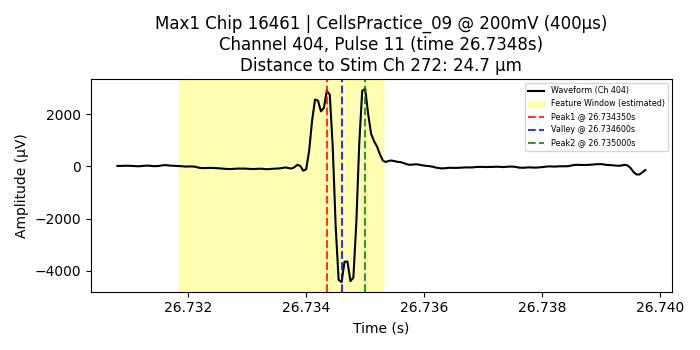

In [13]:
"""Debug Window Printout for DetectPeaks Function - Enhanced with Chip Info""" # LQRyan 20250729
import matplotlib.pyplot as plt

# --- Set these for debugging ---
# debug_channels = ['149', '153', '161', '703', '708', '883', '960', '961', '965']      # List of channel IDs as strings
# debug_channels = ['149', '153', '189', '203', '221', '243', '257', '325', '35', '397', '429', '445', '465', '517', '543', '593', '597', '617', '633', '635', '671', '765', '781', '79', '868', '891', '897', '903', '907', '921', '929', '936', '953', '966', '976', '982']
# debug_channels = ['149','703', '965']
# debug_channels = ['149', '153', '289', '549', '61', '869', '944', '961', '983']
# debug_channels = ['149','1006', '1015', '61', '704', '804', '840', '952', '985']

# debug_channels = ['46','105','997','185','984','946','709','604','830','3','5']
# debug_channels = ['417', '454', '617', '696', '744', '886', '937', '969', '977', '991', '998']

# debug_channels = ['46','105','997','185','984','946','709','604','830','3','5']
# debug_channels = ['105']
# debug_channels = ['149']
# debug_channels = ['17','31','41','53','87','149','505','652','655','793','845','848','901','933','1013']

# debug_channels = ['272']
# debug_channels = ['272', '198', '326', '868', '917', '148', '164', '392', '404']
debug_channels = ['404']

debug_pulse_indices = [11]
# debug_pulse_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# debug_pulse_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # 1-based indices (e.g., [1,2,3] for first three pulses)
# debug_pulse_indices = [13]
# debug_pulse_indices = [3,8,13,18]
# debug_pulse_indices = [3,8,13,14,15]   

for debug_pulse_idx in debug_pulse_indices:
    pulse_time = pulse_times_sec[debug_pulse_idx - 1]
    pulse_width = get_pulse_width(debug_pulse_idx)
    center = int(pulse_time * fs)
    start = center - pre_samples
    end = center + post_samples

    for debug_channel in debug_channels:
        if debug_channel in channel_ids:
            ch_idx = np.where(channel_ids == debug_channel)[0][0]
        else:
            print(f"Channel {debug_channel} not found.")
            continue

        trace = recording_chunk.get_traces(start_frame=start, end_frame=end, return_scaled=True)[:, ch_idx]
        times = np.arange(start, end) / fs

        # Get feature times/amplitudes from wide_df
        peak1_time = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak01_timestamp'].values[0]
        peak1_amp = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak01_µV'].values[0]
        peak2_time = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak02_timestamp'].values[0]
        peak2_amp = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak02_µV'].values[0]
        valley_time = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_valley_timestamp'].values[0]
        valley_amp = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_valley_µV'].values[0]

        # Gets distance to stimulation channel
        distance_to_stim = wide_df.loc[wide_df['channel_id'] == debug_channel, 'distance_to_stim'].values[0]
        
        ## Turn on if you want text printout as well
        # print(f"Channel {debug_channel}, Pulse {debug_pulse_idx} (time {pulse_time:.4f}s):")
        # print(f"  Peak1: time={peak1_time:.6f}, amp={peak1_amp:.2f} µV")
        # print(f"  Valley: time={valley_time:.6f}, amp={valley_amp:.2f} µV")
        # print(f"  Peak2: time={peak2_time:.6f}, amp={peak2_amp:.2f} µV")

        # Plot with enhanced title including chip info and feature-specific shading
        plt.figure(figsize=(7,3.5))
        
        # Plot the waveform first
        plt.plot(times, trace, label=f"Waveform (Ch {debug_channel})", color='black', linewidth=1.5)
        
        # Find the earliest and latest detected features
        feature_times = [peak1_time, valley_time, peak2_time]
        valid_feature_times = [t for t in feature_times if not np.isnan(t)]
        
        if valid_feature_times:
            earliest_feature = min(valid_feature_times)
            latest_feature = max(valid_feature_times)
            
            # Determine what type of feature is the latest
            latest_is_peak = (latest_feature == peak1_time) or (latest_feature == peak2_time)
            
            # Choose appropriate right buffer based on the latest feature type
            right_buffer = right_buffer_peak if latest_is_peak else right_buffer_valley
            
            # Add yellow shading with asymmetric buffers
            shade_start = earliest_feature - left_buffer
            shade_end = latest_feature + right_buffer
            plt.axvspan(shade_start, shade_end, alpha=0.3, color='yellow', 
                       label=f'Feature Window (estimated)')
        
        # Add vertical lines for detected features
        if not np.isnan(peak1_time):
            plt.axvline(peak1_time, color='r', linestyle='--', label=f'Peak1 @ {peak1_time:.6f}s', alpha=0.8)
        if not np.isnan(valley_time):
            plt.axvline(valley_time, color='b', linestyle='--', label=f'Valley @ {valley_time:.6f}s', alpha=0.8)
        if not np.isnan(peak2_time):
            plt.axvline(peak2_time, color='g', linestyle='--', label=f'Peak2 @ {peak2_time:.6f}s', alpha=0.8)
            
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
        
        # Enhanced title with chip information and distance to stim
        title = f"{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV ({pulse_width})\n"
        title += f"Channel {debug_channel}, Pulse {debug_pulse_idx} (time {pulse_time:.4f}s)\n"
        title += f"Distance to Stim Ch {stim_channel_id}: {distance_to_stim:.1f} µm"
        plt.title(title)
        
        plt.legend(loc='upper right', fontsize='xx-small')
        plt.tight_layout()
        plt.show()

In [ ]:
"""Debug Window for DetectPeaks Function - PNG Save Version with Smart Numbering""" # LQRyan 20250731
import matplotlib.pyplot as plt
import os
import glob

# Find the next available figure number with 3-digit format
existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
if existing_figures:
    # Extract numbers from existing figure names
    existing_numbers = []
    for fig_path in existing_figures:
        filename = os.path.basename(fig_path)
        try:
            # Extract number from "Figure_XXX.png" format (handles both 2 and 3 digit)
            number_str = filename.split('_')[1].split('.')[0]
            existing_numbers.append(int(number_str))
        except (IndexError, ValueError):
            continue
    
    # Start from the next available number
    figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
else:
    # No existing figures, start from 1
    figure_counter = 1

print(f"Output directory: {output_dir}")
print(f"Starting figure numbering from: Figure_{figure_counter:03d}")

# --- Set these for debugging ---
# debug_channels = ['105']
# debug_channels = ['46','105','997','185','984','946','709','604','830','3','5']
# debug_channels = ['17','31','41','53','87','149','505','652','655','793','845','848','901','933','1013']
# debug_channels = ['149']
# debug_channels = ['272', '198', '326', '868', '917', '148', '164', '392', '404']

# debug_pulse_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # 1-based indices
# debug_pulse_indices = [3,8,13,18] 
debug_pulse_indices = [3,8,13] 

# Define buffer around detected features in definitions cell above!!!

for debug_pulse_idx in debug_pulse_indices:
    pulse_time = pulse_times_sec[debug_pulse_idx - 1]
    pulse_width = get_pulse_width(debug_pulse_idx)
    center = int(pulse_time * fs)
    start = center - pre_samples
    end = center + post_samples

    for debug_channel in debug_channels:
        if debug_channel in channel_ids:
            ch_idx = np.where(channel_ids == debug_channel)[0][0]
        else:
            print(f"Channel {debug_channel} not found.")
            continue

        trace = recording_chunk.get_traces(start_frame=start, end_frame=end, return_scaled=True)[:, ch_idx]
        times = np.arange(start, end) / fs

        # Get feature times/amplitudes from wide_df
        peak1_time = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak01_timestamp'].values[0]
        peak1_amp = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak01_µV'].values[0]
        peak2_time = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak02_timestamp'].values[0]
        peak2_amp = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_peak02_µV'].values[0]
        valley_time = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_valley_timestamp'].values[0]
        valley_amp = wide_df.loc[wide_df['channel_id'] == debug_channel, f'artifact{debug_pulse_idx:02d}_valley_µV'].values[0]

        # Gets distance to stimulation channel
        distance_to_stim = wide_df.loc[wide_df['channel_id'] == debug_channel, 'distance_to_stim'].values[0]
        
        # Create figure (don't display)
        plt.figure(figsize=(7,3.5))
        
        # Plot the waveform first
        plt.plot(times, trace, label=f"Waveform (Ch {debug_channel})", color='black', linewidth=1.5)
        
        # Find the earliest and latest detected features
        feature_times = [peak1_time, valley_time, peak2_time]
        valid_feature_times = [t for t in feature_times if not np.isnan(t)]
        
        if valid_feature_times:
            earliest_feature = min(valid_feature_times)
            latest_feature = max(valid_feature_times)
            
            # Determine what type of feature is the latest
            latest_is_peak = (latest_feature == peak1_time) or (latest_feature == peak2_time)
            
            # Choose appropriate right buffer based on the latest feature type
            right_buffer = right_buffer_peak if latest_is_peak else right_buffer_valley
            
            # Add yellow shading with asymmetric buffers
            shade_start = earliest_feature - left_buffer
            shade_end = latest_feature + right_buffer
            plt.axvspan(shade_start, shade_end, alpha=0.3, color='yellow', 
                       label=f'Feature Window (estimated)')
        
        # Add vertical lines for detected features
        if not np.isnan(peak1_time):
            plt.axvline(peak1_time, color='r', linestyle='--', label=f'Peak1 @ {peak1_time:.6f}s', alpha=0.8)
        if not np.isnan(valley_time):
            plt.axvline(valley_time, color='b', linestyle='--', label=f'Valley @ {valley_time:.6f}s', alpha=0.8)
        if not np.isnan(peak2_time):
            plt.axvline(peak2_time, color='g', linestyle='--', label=f'Peak2 @ {peak2_time:.6f}s', alpha=0.8)
            
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
        
        # Enhanced title with chip information and distance to stim
        title = f"{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV ({pulse_width})\n"
        title += f"Channel {debug_channel}, Pulse {debug_pulse_idx} (time {pulse_time:.4f}s)\n"
        title += f"Distance to Stim Ch {stim_channel_id}: {distance_to_stim:.1f} µm"
        plt.title(title)
        
        plt.legend(loc='upper right', fontsize='xx-small')
        plt.tight_layout()
        
        # Save figure as PNG with 3-digit numbering
        filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
        
        # Close figure to free memory
        plt.close()
        
        # Increment counter
        figure_counter += 1

print(f"\nAll figures saved to: {os.path.abspath(output_dir)}")
print(f"Total figures saved: {figure_counter - (max(existing_numbers) + 1 if existing_figures else 1)}")
print(f"Figure numbering ended at: Figure_{figure_counter - 1:03d}")

In [ ]:
"""Save dataframes to excel once data is good enough""" #I should've been doing this the whole time... - LQRyan 20250730
import os

# # Get save directory from user input REMEMBER THAT SAVES GO TO APPENDED PATH BECAUSE WE ARE IN DOCKER!!!!!!!
# save_directory = input("Enter save directory path (or press Enter for default directory): ").strip()

# # Use current directory if no input provided
# if not save_directory:
    
#     save_directory = "/home/benshalom/AnalysisResults"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

print("="*80)
print(f"Save directory: {save_directory}")
print(f"Directory exists: {os.path.exists(save_directory)}")

# Create base filename with chip information
base_filename = f'VoltStimArtAnal_Media_LQR_{chip_type}_{chip_id}_{test_number}_{voltage}mV'
print(f"Base filename: {base_filename}")

# Check if DataFrames exist
dataframes_to_save = [
    ('restructured_df', restructured_df),
    ('wide_df', wide_df), 
    ('channel_df', channel_df)
]

for df_name, df_var in dataframes_to_save:
    try:
        # Use os.path.join for proper path handling
        filename = os.path.join(save_directory, f'{base_filename}_{df_name}.xlsx')
        print(f"filename: {filename}")
        df_var.to_excel(filename, index=False)
        print(f"✅ Saved {df_name} to {os.path.basename(filename)}")
        
    except NameError:
        print(f"❌ {df_name} not found - make sure you've run the artifact analysis cell first!")
    except Exception as e:
        print(f"❌ Error saving {df_name}: {e}")

print(f"\nAll files saved to: {save_directory}")
print("="*80)

In [ ]:
"""Interactive matplotlib selection of channels""" ## Unchanged since before Artifact Analysis Project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

# Enable interactive matplotlib
%matplotlib widget

channels_to_highlight =[]

# Setup figure
fig, ax = plt.subplots()
c = ['gray'] * len(channel_ids)  # Default color for all channels
for ch in channels_to_highlight: 
    if ch in channel_ids:
        idx = np.where(channel_ids == ch)[0][0]
        c[idx] = 'blue'  # Highlight specified channels in red   

sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Channels', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")

# Scatter for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Channels')
selected_channels = []

# Create an output widget for displaying messages
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_channels
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = channel_ids[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_channels = np.unique(np.concatenate((selected_channels, new_selection)))
    else:  # Overwrite selection
        selected_channels = new_selection

    selected_plot.set_offsets(locs[np.isin(channel_ids, selected_channels)])
    fig.canvas.draw_idle()

    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_channels)} channels")
        print(selected_channels)

# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Channels",
    button_style='success',
    tooltip='Save selected channel IDs to file'
)

# Define callback to save to file
def save_selected_channels_to_file(b):
    if len(selected_channels) == 0:
        with output:
            output.clear_output()
            print("No channels selected to save.")
        return

    save_path = "selected_channels.txt"
    with open(save_path, "w") as f:
        for ch in selected_channels:
            f.write(f"{ch}\n")

    with output:
        output.clear_output()
        print(f"Saved {len(selected_channels)} channel IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_channels_to_file)

# Display the save button and output widget
display(widgets.VBox([save_button, output]))

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Debug - Find closest spikes after feature windows with amplitude info and plot traces (filtered by spike detection window) - LQRyan 2025-08-04
import os
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import detect_peaks

# Replace with the desired channel IDs as strings
channels_to_debug = ['198', '326', '868', '917', '148', '164', '392', '404'] # Debug these channels

fs = recording_chunk.get_sampling_frequency()
start_time = 26 # Start time in seconds
end_time = 31 # End time in seconds

# Print the detected spikes window
print("="*80)
print(f"DETECTED SPIKES WINDOW: {start_time}s to {end_time}s ({end_time - start_time}s duration)")
print("="*80)

# Filter pulse_times_sec to only include pulses within the spike detection window
pulses_in_window = [pulse_time for pulse_time in pulse_times_sec 
                   if start_time <= pulse_time <= end_time]

print(f"Original pulses: {len(pulse_times_sec)} total")
print(f"Pulses within spike detection window: {len(pulses_in_window)} total")
print(f"Filtered pulse times: {pulses_in_window}")
print()

if not pulses_in_window:
    print("⚠️ No pulses found within the spike detection window!")
    print("Consider adjusting your start_time/end_time or pulse_times_sec")
else:
    # Get traces for the specified range
    traces = recording_chunk.get_traces(
        start_frame=int(start_time * fs),
        end_frame=int(end_time * fs),
        segment_index=0,
        return_scaled=True
    )

    # Parameters for spike detection
    peak_sign = "neg"  # Detect negative peaks
    std_multiplier = 100  # Threshold: 1 standard deviation from the mean

    # Function to check if a spike falls within any feature window
    def is_spike_in_feature_window(spike_sample, start_sample, fs, pulse_times_sec, left_buffer, right_buffer_peak, right_buffer_valley, channel_id):
        """
        Check if a spike sample falls within any artifact feature window
        """
        spike_time = (start_sample + spike_sample) / fs  # Convert to absolute time
        
        for pulse_time in pulse_times_sec:
            # Get feature times for this pulse and channel from wide_df
            pulse_idx = pulse_times_sec.index(pulse_time) + 1
            
            try:
                peak1_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{pulse_idx:02d}_peak01_timestamp'].values[0]
                peak2_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{pulse_idx:02d}_peak02_timestamp'].values[0]
                valley_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{pulse_idx:02d}_valley_timestamp'].values[0]
                
                # Find the earliest and latest detected features (same logic as debug window)
                feature_times = [peak1_time, valley_time, peak2_time]
                valid_feature_times = [t for t in feature_times if not np.isnan(t)]
                
                if valid_feature_times:
                    earliest_feature = min(valid_feature_times)
                    latest_feature = max(valid_feature_times)
                    
                    # Determine what type of feature is the latest
                    latest_is_peak = (latest_feature == peak1_time) or (latest_feature == peak2_time)
                    
                    # Choose appropriate right buffer based on the latest feature type
                    right_buffer = right_buffer_peak if latest_is_peak else right_buffer_valley
                    
                    # Define feature window
                    window_start = earliest_feature - left_buffer
                    window_end = latest_feature + right_buffer
                    
                    # Check if spike falls within this window
                    if window_start <= spike_time <= window_end:
                        return True
                        
            except (IndexError, KeyError):
                # No feature data for this channel/pulse combination
                continue
        
        return False

    def get_feature_window_end(channel_id, filtered_pulse_times, left_buffer, right_buffer_peak, right_buffer_valley):
        """
        Get the end times of all feature windows for a given channel (only for pulses in spike window)
        """
        window_ends = []
        
        for pulse_time in filtered_pulse_times:
            # Find the original pulse index in the full pulse_times_sec list
            original_pulse_idx = pulse_times_sec.index(pulse_time) + 1
            
            try:
                peak1_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{original_pulse_idx:02d}_peak01_timestamp'].values[0]
                peak2_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{original_pulse_idx:02d}_peak02_timestamp'].values[0]
                valley_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{original_pulse_idx:02d}_valley_timestamp'].values[0]
                
                # Find the earliest and latest detected features
                feature_times = [peak1_time, valley_time, peak2_time]
                valid_feature_times = [t for t in feature_times if not np.isnan(t)]
                
                if valid_feature_times:
                    earliest_feature = min(valid_feature_times)
                    latest_feature = max(valid_feature_times)
                    
                    # Determine what type of feature is the latest
                    latest_is_peak = (latest_feature == peak1_time) or (latest_feature == peak2_time)
                    
                    # Choose appropriate right buffer based on the latest feature type
                    right_buffer = right_buffer_peak if latest_is_peak else right_buffer_valley
                    
                    # Calculate window end
                    window_end = latest_feature + right_buffer
                    window_ends.append((original_pulse_idx, window_end, pulse_time))
                    
            except (IndexError, KeyError):
                # No feature data for this channel/pulse combination
                continue
        
        return window_ends

    # Debug printout
    print("="*80)
    print(f"DEBUG: CLOSEST SPIKES AFTER FEATURE WINDOWS (FILTERED)")
    print(f"Chip: {chip_type} {chip_id} | {test_number} @ {voltage}mV")
    print(f"Only analyzing pulses within spike detection window ({start_time}s - {end_time}s)")
    print("="*80)

    # Pair channel IDs with their indices
    channels_to_debug_pairs = [
        (ch, np.where(channel_ids == ch)[0][0]) for ch in channels_to_debug if ch in channel_ids
    ]

    for ch_id, idx in channels_to_debug_pairs:
        print(f"\nChannel {ch_id}:")
        print("-" * 40)
        
        # Get trace for this channel
        trace = traces[:, idx]
        
        # Detect all spikes in the trace
        peaks_sample_inds, _ = detect_peaks(trace, peak_sign, std_multiplier)
        peaks_sample_inds = peaks_sample_inds.astype(int)
        
        # Convert spike sample indices to absolute time
        spike_times = (int(start_time * fs) + peaks_sample_inds) / fs
        spike_amplitudes = trace[peaks_sample_inds]
        
        # Filter out spikes that fall within feature windows
        filtered_peaks = []
        for peak_sample in peaks_sample_inds:
            if not is_spike_in_feature_window(peak_sample, int(start_time * fs), fs, 
                                            pulse_times_sec, left_buffer, 
                                            right_buffer_peak, right_buffer_valley, ch_id):
                filtered_peaks.append(peak_sample)
        
        filtered_peaks = np.array(filtered_peaks)
        
        # Get feature window end times for this channel (only for pulses in window)
        window_ends = get_feature_window_end(ch_id, pulses_in_window, left_buffer, 
                                           right_buffer_peak, right_buffer_valley)
        
        if not window_ends:
            print(f"  No feature windows found for channel {ch_id} within spike detection window")
            continue
        
        # Find closest spike after each feature window
        for pulse_idx, window_end, pulse_time in window_ends:
            # Find spikes that occur after this window ends
            spikes_after_window = spike_times > window_end
            
            if not np.any(spikes_after_window):
                print(f"  Pulse {pulse_idx} (t={pulse_time:.3f}s): No spikes after window (ends at {window_end:.6f}s)")
                continue
            
            # Get times and amplitudes of spikes after the window
            post_window_times = spike_times[spikes_after_window]
            post_window_amplitudes = spike_amplitudes[spikes_after_window]
            
            # Find the closest one (minimum time difference)
            time_differences = post_window_times - window_end
            closest_idx = np.argmin(time_differences)
            
            closest_time = post_window_times[closest_idx]
            closest_amplitude = post_window_amplitudes[closest_idx]
            time_after_window = time_differences[closest_idx]
            
            print(f"  Pulse {pulse_idx} (t={pulse_time:.3f}s): Window ends at {window_end:.6f}s")
            print(f"    → Closest spike: {time_after_window*1000:.2f}ms later at {closest_time:.6f}s, amplitude: {closest_amplitude:.1f}µV")

    print("\n" + "="*80)
    print(f"Analysis complete. Searched for spikes from {start_time}s to {end_time}s")
    print(f"Analyzed {len(pulses_in_window)} pulses within spike detection window")
    print(f"Spike detection parameters: {peak_sign} peaks, {std_multiplier}x std threshold")
    print(f"Feature window buffers: left={left_buffer*1000:.2f}ms, right_peak={right_buffer_peak*1000:.2f}ms, right_valley={right_buffer_valley*1000:.2f}ms")
    print("="*80)

    # ===== TRACE PLOTTING SECTION =====
    print("\n" + "="*80)
    print("GENERATING TRACE PLOTS WITH FILTERED SPIKES")
    print("="*80)
    
    # Adjust figure height dynamically based on the number of channels
    plt.figure(figsize=(12, len(channels_to_debug) * 2.5))

    # Store y-axis positions and labels for labeling
    yticks_positions = []
    yticks_labels = []

    # Offset for trace spacing
    offset = 500
    spike_marker_offset = 100

    # Loop through the channels and plot each
    for i, (ch_id, idx) in enumerate(channels_to_debug_pairs):
        trace = traces[:, idx]

        # Detect peaks using the detect_peaks function
        peaks_sample_inds, _ = detect_peaks(trace, peak_sign, std_multiplier)
        peaks_sample_inds = peaks_sample_inds.astype(int)
        
        # Filter out spikes that fall within feature windows
        filtered_peaks = []
        for peak_sample in peaks_sample_inds:
            if not is_spike_in_feature_window(peak_sample, int(start_time * fs), fs, 
                                            pulse_times_sec, left_buffer, 
                                            right_buffer_peak, right_buffer_valley, ch_id):
                filtered_peaks.append(peak_sample)
        
        filtered_peaks = np.array(filtered_peaks)
        
        # Plot the trace with increased spacing
        plt.plot(
            trace + i * offset,
            label=f'Channel {ch_id}',
            rasterized=True,
            linewidth=0.5
        )

        # Mark the filtered spikes with red triangles
        if len(filtered_peaks) > 0:
            plt.plot(
                filtered_peaks,
                trace[filtered_peaks] + i * offset + spike_marker_offset,
                'rv',
                markersize=4,
                label=f'Spikes Channel {ch_id} (excluding artifact windows)'
            )

        # Add y-axis tick position and label
        yticks_positions.append(i * offset)
        yticks_labels.append(f'Channel {ch_id}')

    # --- Add file name to the title ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

    # Customize the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Time (samples)')
    plt.title(f'Traces with Detected Spikes (Artifact Windows Excluded)\nChip: {chip_type} {chip_id} | {test_number} @ {voltage}mV\nFile: {file_name}')

    # Add y-axis ticks

DETECTED SPIKES WINDOW: 15s to 31s (16s duration)
Original pulses: 15 total
Pulses within spike detection window: 10 total
Filtered pulse times: [15.8682, 16.8692, 17.8702, 18.8712, 19.8722, 26.7348, 27.7358, 28.7368, 29.7378, 30.7388]

DEBUG: NEXT TWO SPIKES AFTER FEATURE WINDOWS (FILTERED)
Chip: Max1 16461 | CellsPractice_09 @ 200mV
Only analyzing pulses within spike detection window (15s - 31s)

Channel 404:
----------------------------------------
  Pulse 6 (t=15.868s): Window 15.865450s to 15.868650s
    → 1st spike: 0.30ms later at 15.868950s, amplitude: -421.7µV
    → 2nd spike: 338.45ms later at 16.207100s, amplitude: -308.4µV
  Pulse 7 (t=16.869s): Window 16.866450s to 16.869650s
    → 1st spike: 0.70ms later at 16.870350s, amplitude: -346.2µV
    → 2nd spike: 767.90ms later at 17.637550s, amplitude: -201.4µV
  Pulse 8 (t=17.870s): Window 17.867450s to 17.870650s
    → 1st spike: 0.10ms later at 17.870750s, amplitude: -302.1µV
    → 2nd spike: 2.35ms later at 17.873000s, ampli

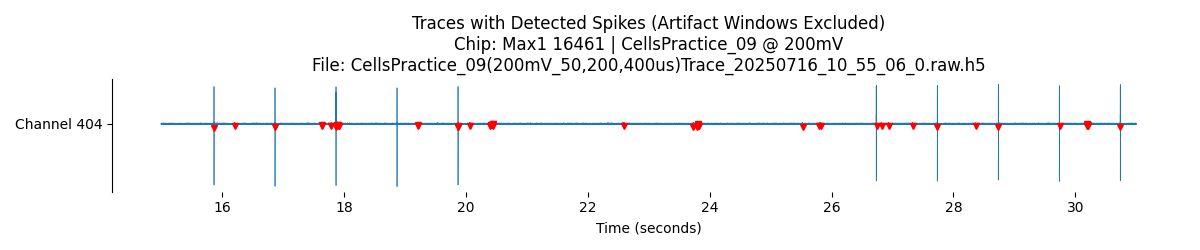

Trace plot generated for 1 channels
Spikes within artifact windows were excluded from visualization


In [14]:
# Debug - Find closest TWO spikes after feature windows with amplitude info - LQRyan 2025-08-04
import os
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import detect_peaks

# Replace with the desired channel IDs as strings
channels_to_debug = ['404']

fs = recording_chunk.get_sampling_frequency()
start_time = 15 # Start time in seconds
end_time = 31 # End time in seconds

# Print the detected spikes window
print("="*80)
print(f"DETECTED SPIKES WINDOW: {start_time}s to {end_time}s ({end_time - start_time}s duration)")
print("="*80)

# Filter pulse_times_sec to only include pulses within the spike detection window
pulses_in_window = [pulse_time for pulse_time in pulse_times_sec 
                   if start_time <= pulse_time <= end_time]

print(f"Original pulses: {len(pulse_times_sec)} total")
print(f"Pulses within spike detection window: {len(pulses_in_window)} total")
print(f"Filtered pulse times: {pulses_in_window}")
print()

if not pulses_in_window:
    print("⚠️ No pulses found within the spike detection window!")
    print("Consider adjusting your start_time/end_time or pulse_times_sec")
else:
    # Get traces for the specified range
    traces = recording_chunk.get_traces(
        start_frame=int(start_time * fs),
        end_frame=int(end_time * fs),
        segment_index=0,
        return_scaled=True
    )

    # Parameters for spike detection
    peak_sign = "neg"  # Detect negative peaks
    std_multiplier = 100  # Threshold: 1 standard deviation from the mean

    # Function to check if a spike falls within any feature window
    def is_spike_in_feature_window(spike_sample, start_sample, fs, pulse_times_sec, left_buffer, right_buffer_peak, right_buffer_valley, channel_id):
        """
        Check if a spike sample falls within any artifact feature window
        """
        spike_time = (start_sample + spike_sample) / fs  # Convert to absolute time
        
        for pulse_time in pulse_times_sec:
            # Get feature times for this pulse and channel from wide_df
            pulse_idx = pulse_times_sec.index(pulse_time) + 1
            
            try:
                peak1_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{pulse_idx:02d}_peak01_timestamp'].values[0]
                peak2_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{pulse_idx:02d}_peak02_timestamp'].values[0]
                valley_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{pulse_idx:02d}_valley_timestamp'].values[0]
                
                # Find the earliest and latest detected features (same logic as debug window)
                feature_times = [peak1_time, valley_time, peak2_time]
                valid_feature_times = [t for t in feature_times if not np.isnan(t)]
                
                if valid_feature_times:
                    earliest_feature = min(valid_feature_times)
                    latest_feature = max(valid_feature_times)
                    
                    # Determine what type of feature is the latest
                    latest_is_peak = (latest_feature == peak1_time) or (latest_feature == peak2_time)
                    
                    # Choose appropriate right buffer based on the latest feature type
                    right_buffer = right_buffer_peak if latest_is_peak else right_buffer_valley
                    
                    # Define feature window
                    window_start = earliest_feature - left_buffer
                    window_end = latest_feature + right_buffer
                    
                    # Check if spike falls within this window
                    if window_start <= spike_time <= window_end:
                        return True
                        
            except (IndexError, KeyError):
                # No feature data for this channel/pulse combination
                continue
        
        return False

    def get_feature_window_details(channel_id, filtered_pulse_times, left_buffer, right_buffer_peak, right_buffer_valley):
        """
        Get the start and end times of all feature windows for a given channel (only for pulses in spike window)
        """
        window_details = []
        
        for pulse_time in filtered_pulse_times:
            # Find the original pulse index in the full pulse_times_sec list
            original_pulse_idx = pulse_times_sec.index(pulse_time) + 1
            
            try:
                peak1_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{original_pulse_idx:02d}_peak01_timestamp'].values[0]
                peak2_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{original_pulse_idx:02d}_peak02_timestamp'].values[0]
                valley_time = wide_df.loc[wide_df['channel_id'] == channel_id, f'artifact{original_pulse_idx:02d}_valley_timestamp'].values[0]
                
                # Find the earliest and latest detected features
                feature_times = [peak1_time, valley_time, peak2_time]
                valid_feature_times = [t for t in feature_times if not np.isnan(t)]
                
                if valid_feature_times:
                    earliest_feature = min(valid_feature_times)
                    latest_feature = max(valid_feature_times)
                    
                    # Determine what type of feature is the latest
                    latest_is_peak = (latest_feature == peak1_time) or (latest_feature == peak2_time)
                    
                    # Choose appropriate right buffer based on the latest feature type
                    right_buffer = right_buffer_peak if latest_is_peak else right_buffer_valley
                    
                    # Calculate window start and end
                    window_start = earliest_feature - left_buffer
                    window_end = latest_feature + right_buffer
                    window_details.append((original_pulse_idx, window_start, window_end, pulse_time))
                    
            except (IndexError, KeyError):
                # No feature data for this channel/pulse combination
                continue
        
        return window_details

    # Debug printout
    print("="*80)
    print(f"DEBUG: NEXT TWO SPIKES AFTER FEATURE WINDOWS (FILTERED)")
    print(f"Chip: {chip_type} {chip_id} | {test_number} @ {voltage}mV")
    print(f"Only analyzing pulses within spike detection window ({start_time}s - {end_time}s)")
    print("="*80)

    # Pair channel IDs with their indices
    channels_to_debug_pairs = [
        (ch, np.where(channel_ids == ch)[0][0]) for ch in channels_to_debug if ch in channel_ids
    ]

    for ch_id, idx in channels_to_debug_pairs:
        print(f"\nChannel {ch_id}:")
        print("-" * 40)
        
        # Get trace for this channel
        trace = traces[:, idx]
        
        # Detect all spikes in the trace
        peaks_sample_inds, _ = detect_peaks(trace, peak_sign, std_multiplier)
        peaks_sample_inds = peaks_sample_inds.astype(int)
        
        # Convert spike sample indices to absolute time
        spike_times = (int(start_time * fs) + peaks_sample_inds) / fs
        spike_amplitudes = trace[peaks_sample_inds]
        
        # Filter out spikes that fall within feature windows
        filtered_peaks = []
        for peak_sample in peaks_sample_inds:
            if not is_spike_in_feature_window(peak_sample, int(start_time * fs), fs, 
                                            pulse_times_sec, left_buffer, 
                                            right_buffer_peak, right_buffer_valley, ch_id):
                filtered_peaks.append(peak_sample)
        
        filtered_peaks = np.array(filtered_peaks)
        
        # Get feature window details for this channel (only for pulses in window)
        window_details = get_feature_window_details(ch_id, pulses_in_window, left_buffer, 
                                                  right_buffer_peak, right_buffer_valley)
        
        if not window_details:
            print(f"  No feature windows found for channel {ch_id} within spike detection window")
            continue
        
        # Find next TWO spikes after each feature window
        for pulse_idx, window_start, window_end, pulse_time in window_details:
            # Find spikes that occur after this window ends
            spikes_after_window = spike_times > window_end
            
            if not np.any(spikes_after_window):
                print(f"  Pulse {pulse_idx} (t={pulse_time:.3f}s): Window {window_start:.6f}s to {window_end:.6f}s")
                print(f"    → No spikes after window")
                continue
            
            # Get times and amplitudes of spikes after the window
            post_window_times = spike_times[spikes_after_window]
            post_window_amplitudes = spike_amplitudes[spikes_after_window]
            
            # Sort by time to get them in chronological order
            sort_indices = np.argsort(post_window_times)
            sorted_times = post_window_times[sort_indices]
            sorted_amplitudes = post_window_amplitudes[sort_indices]
            
            print(f"  Pulse {pulse_idx} (t={pulse_time:.3f}s): Window {window_start:.6f}s to {window_end:.6f}s")
            
            # Report the next two spikes (or however many are available)
            num_spikes_to_report = min(2, len(sorted_times))
            for i in range(num_spikes_to_report):
                spike_time = sorted_times[i]
                spike_amplitude = sorted_amplitudes[i]
                time_after_window = (spike_time - window_end) * 1000  # Convert to ms
                
                spike_number = "1st" if i == 0 else "2nd"
                print(f"    → {spike_number} spike: {time_after_window:.2f}ms later at {spike_time:.6f}s, amplitude: {spike_amplitude:.1f}µV")
            
            if len(sorted_times) < 2:
                missing_spikes = 2 - len(sorted_times)
                print(f"    → Only {len(sorted_times)} spike(s) found after window (missing {missing_spikes})")

    print("\n" + "="*80)
    print(f"Analysis complete. Searched for spikes from {start_time}s to {end_time}s")
    print(f"Analyzed {len(pulses_in_window)} pulses within spike detection window")
    print(f"Spike detection parameters: {peak_sign} peaks, {std_multiplier}x std threshold")
    print(f"Feature window buffers: left={left_buffer*1000:.2f}ms, right_peak={right_buffer_peak*1000:.2f}ms, right_valley={right_buffer_valley*1000:.2f}ms")
    print("="*80)

    # ===== TRACE PLOTTING SECTION =====
    print("\n" + "="*80)
    print("GENERATING TRACE PLOTS WITH FILTERED SPIKES")
    print("="*80)
    
    # Adjust figure height dynamically based on the number of channels
    plt.figure(figsize=(12, len(channels_to_debug) * 2.5))

    # Store y-axis positions and labels for labeling
    yticks_positions = []
    yticks_labels = []

    # Offset for trace spacing
    offset = 500
    spike_marker_offset = 100

    # Create time axis in seconds
    time_axis = np.linspace(start_time, end_time, traces.shape[0])

    # Loop through the channels and plot each
    for i, (ch_id, idx) in enumerate(channels_to_debug_pairs):
        trace = traces[:, idx]

        # Detect peaks using the detect_peaks function
        peaks_sample_inds, _ = detect_peaks(trace, peak_sign, std_multiplier)
        peaks_sample_inds = peaks_sample_inds.astype(int)
        
        # Filter out spikes that fall within feature windows
        filtered_peaks = []
        for peak_sample in peaks_sample_inds:
            if not is_spike_in_feature_window(peak_sample, int(start_time * fs), fs, 
                                            pulse_times_sec, left_buffer, 
                                            right_buffer_peak, right_buffer_valley, ch_id):
                filtered_peaks.append(peak_sample)
        
        filtered_peaks = np.array(filtered_peaks)
        
        # Plot the trace with increased spacing using time axis
        plt.plot(
            time_axis,
            trace + i * offset,
            label=f'Channel {ch_id}',
            rasterized=True,
            linewidth=0.5
        )

        # Mark the filtered spikes with red triangles
        if len(filtered_peaks) > 0:
            # Convert filtered peak indices to time
            filtered_peak_times = time_axis[filtered_peaks]
            plt.plot(
                filtered_peak_times,
                trace[filtered_peaks] + i * offset + spike_marker_offset,
                'rv',
                markersize=4,
                label=f'Spikes Channel {ch_id} (excluding artifact windows)'
            )

        # Add y-axis tick position and label
        yticks_positions.append(i * offset)
        yticks_labels.append(f'Channel {ch_id}')

    # --- Add file name to the title ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

    # Customize the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Time (seconds)')  # Changed from 'Time (samples)' to 'Time (seconds)'
    plt.title(f'Traces with Detected Spikes (Artifact Windows Excluded)\nChip: {chip_type} {chip_id} | {test_number} @ {voltage}mV\nFile: {file_name}')

    # Add y-axis ticks with channel names
    plt.yticks(yticks_positions, yticks_labels)

    plt.tight_layout()
    plt.show()

    print(f"Trace plot generated for {len(channels_to_debug)} channels")
    print(f"Spikes within artifact windows were excluded from visualization")

ToggleButtons(description='X-Axis:', index=1, options=(('Samples', 'samples'), ('Time (s)', 'time')), value='t…

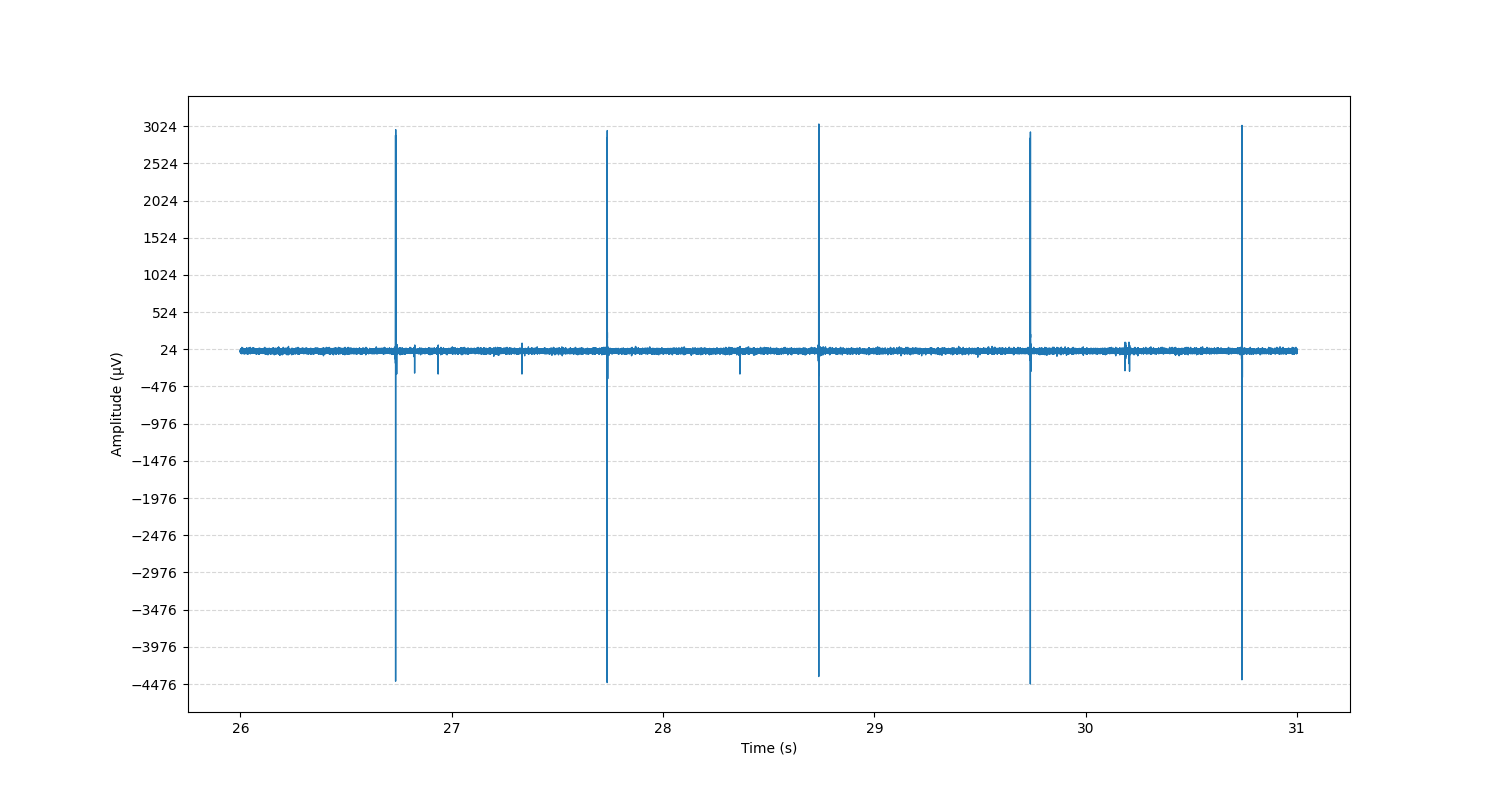

In [15]:
# Interactive matplotlib traces inspector (updated) - LQRyan 2025-06-20 
"""There us a bug where sometimes you have to switch to seconds and then back to samples before it desplays - may be a memory issue on my pc?"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

# Enable interactive matplotlib
%matplotlib widget

# fs and recording_chunk are defined elsewhere
# fs = sample rate, e.g., 20000
# recording_chunk = your data source

# Setup figure
start = int(26 * fs)
end = int(31 * fs)
traces = recording_chunk.get_traces(start_frame=start, end_frame=end, channel_ids=['404'], segment_index=0, return_scaled=True)

n_samples = traces.shape[0]
time = np.arange(start, end) / fs  # In seconds

# Widget to toggle x-axis
xaxis_mode = widgets.ToggleButtons(
    options=[('Samples', 'samples'), ('Time (s)', 'time')],
    value='samples',
    description='X-Axis:',
    disabled=False,
    button_style=''
)

def plot_trace(x_mode='samples'):
    plt.figure(figsize=(15,8))
    if x_mode == 'samples':
        x_vals = np.arange(start, end)
        plt.xlabel('Sample')
    else:
        x_vals = time
        plt.xlabel('Time (s)')
    plt.plot(x_vals, traces, lw=1)
    plt.ylabel('Amplitude (µV)')
    
    # Set y-axis ticks for higher resolution (lower step# = Higher Resolution)
    y_min, y_max = np.min(traces), np.max(traces)
    y_ticks = np.arange(np.floor(y_min/2)*2, np.ceil(y_max/2)*2 + 2, 500)  # Sets (y_min, y_max, step #) to ensure data is in bounds
    plt.yticks(y_ticks)
    plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
    plt.show()

def on_xaxis_change(change):
    clear_output(wait=True)
    display(xaxis_mode)
    plot_trace(xaxis_mode.value)

xaxis_mode.observe(on_xaxis_change, names='value')

display(xaxis_mode)
plot_trace('samples')
plt.close('all') # Close any previous plots to avoid clutter

In [ ]:
# Debugging for MAD  Print mean and standard deviation for each channel and pulse window #debug + helps identify values for artifact detection

for pulse_time in pulse_times_sec:
    center = int(pulse_time * fs)
    start = center - pre_samples
    end = center + post_samples
    trace = recording_chunk.get_traces(start_frame=start, end_frame=end, return_scaled=True)  # (n_samples, n_channels)
    for ch_idx, ch_id in enumerate(channel_ids):
        waveform = trace[:, ch_idx]
        mean_val = np.mean(waveform)
        median_val = np.median(waveform)
        std_val = np.std(waveform)
        mad = np.median(np.abs(waveform - np.median(waveform)))
        noise_std = mad / 0.6745
        print(f"Pulse {pulse_time:.3f}s | Channel {ch_id}: mean = {mean_val:.3f}, median = {median_val:.3f}, std = {std_val:.3f}, robust std (MAD) = {noise_std:.3f}")


In [ ]:
"""Heatmaps""" ## of peak1 µV values by x/y location for each pulse, excluding selected channels and filtering by distance 
# Mk05b - LQRyan 2025-08-01 - Fixed NaN handling
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

%matplotlib widget

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)

num_pulses = len(pulse_times_sec)
ncols = 5  # Number of plots per row
nrows = 4  # Number of rows

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharey=True)
axes = axes.flatten()

for i, pulse_time in enumerate(pulse_times_sec):
    colname = f'artifact{(i+1):02d}_peak01_µV'
    x = plot_df['x']
    y = plot_df['y']
    amp = plot_df[colname]
    
    ax = axes[i]
    
    # Get pulse width for this pulse number
    pulse_width = get_pulse_width(i+1)  # i+1 because pulse numbers are 1-based
    
    # Check if all amplitude values are NaN
    if np.all(np.isnan(amp)):
        # Display "No valid data" message
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        # Add stimulation channel marker
        ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
                   label=f'Stim Ch {stim_channel_id}', zorder=5)
        
        # Set axis limits and labels
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(ylim_min, ylim_max)
        ax.set_title(f'Pulse {i+1} ({pulse_width})\nTime: {pulse_time:.3f}s')
        ax.set_xlabel('X (μm)')
        if i % ncols == 0:
            ax.set_ylabel('Y (μm)')
        
        continue  # Skip to next pulse
    
    # Normal processing for pulses with valid data
    pulse_max = np.nanmax(amp)
    
    # Handle case where pulse_max is NaN (shouldn't happen after the check above, but safety net)
    if np.isnan(pulse_max):
        pulse_max = 100  # Set a reasonable default
    
    rounded_max = int(np.ceil(pulse_max / 50.0) * 50)
    bounds = np.arange(0, rounded_max + 50, 50)
    
    # Define anchor colors for colormap
    anchor_colors = [
        (0.85, 0.92, 1.0),   # very pale blue (0)
        (0.3, 0.6, 1.0),     # blue 
        (0.0, 0.8, 0.5),     # green 
        (1.0, 1.0, 0.3),     # yellow 
        (1.0, 0.6, 0.0),     # orange 
        (1.0, 0.0, 0.0),     # red (max)
    ]
    
    # Interpolate anchor colors
    from scipy.interpolate import interp1d
    anchor_pos = np.linspace(0, 1, len(anchor_colors))
    n_colors = 256
    interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
    xs = np.linspace(0, 1, n_colors)
    gradient_colors = np.stack([
        interp(0)(xs),
        interp(1)(xs),
        interp(2)(xs)
    ], axis=1)
    cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)
    norm = plt.Normalize(bounds[0], bounds[-1])

    # Create scatter plot
    sc = ax.scatter(x, y, c=amp, cmap=cmap, norm=norm, s=60, edgecolor='k')
    
    # Add stimulation channel marker
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # Set axis limits
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(f'Pulse {i+1} ({pulse_width})\nTime: {pulse_time:.3f}s')
    ax.set_xlabel('X (μm)')
    if i % ncols == 0:
        ax.set_ylabel('Y (μm)')
    
    # Add colorbar
    cbar_ticks = np.linspace(0, rounded_max, 11)
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label('Peak1 Amplitude (µV)')

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Add file name to the title
print(f"Stim Channel = {stim_channel_id}")
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Heatmaps of Peak1 µV by Channel Location for Each Pulse\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)
else:
    plt.suptitle(f'Heatmaps of Peak1 µV by Channel Location for Each Pulse\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close()

In [ ]:
# Heatmaps of peak2 µV values by x/y location for each pulse, excluding selected channels and filtering by distance 
# Mk05b - LQRyan 2025-08-01 - Fixed NaN handling
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

%matplotlib widget

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    # exclude_channels = ['102'] #highly reccomend excluding stimulation channels -LQRyan
    # exclude_channels = ['149','153']
    exclude_channels = [stim_channel_id]

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)

num_pulses = len(pulse_times_sec)
ncols = 5  # Number of plots per row - changed from 4 to 5
nrows = 4  # Number of rows - changed from int(np.ceil(num_pulses / ncols)) to 4

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharey=True)  # Updated figsize for 5 columns
axes = axes.flatten()

for i, pulse_time in enumerate(pulse_times_sec):
    colname = f'artifact{(i+1):02d}_peak02_µV'  # Changed to peak02
    x = plot_df['x']
    y = plot_df['y']
    amp = plot_df[colname]
    
    ax = axes[i]
    
    # Get pulse width for this pulse number
    pulse_width = get_pulse_width(i+1)  # i+1 because pulse numbers are 1-based
    
    # Check if all amplitude values are NaN
    if np.all(np.isnan(amp)):
        # Display "No valid data" message
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        # Add stimulation channel marker
        ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
                   label=f'Stim Ch {stim_channel_id}', zorder=5)
        
        # Set axis limits and labels
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(ylim_min, ylim_max)
        ax.set_title(f'Pulse {i+1} ({pulse_width})\nTime: {pulse_time:.3f}s')
        ax.set_xlabel('X (μm)')
        if i % ncols == 0:
            ax.set_ylabel('Y (μm)')
        
        continue  # Skip to next pulse
    
    # Normal processing for pulses with valid data
    pulse_max = np.nanmax(amp)
    
    # Handle case where pulse_max is NaN (shouldn't happen after the check above, but safety net)
    if np.isnan(pulse_max):
        pulse_max = 100  # Set a reasonable default
    
    rounded_max = int(np.ceil(pulse_max / 50.0) * 50)
    bounds = np.arange(0, rounded_max + 50, 50)

    # Define anchor colors for each bin edge (must be one more than n_bins)
    anchor_colors = [
        (0.85, 0.92, 1.0),   # very pale blue (0)
        (0.3, 0.6, 1.0),     # blue 
        (0.0, 0.8, 0.5),     # green 
        (1.0, 1.0, 0.3),     # yellow 
        (1.0, 0.6, 0.0),     # orange 
        (1.0, 0.0, 0.0),     # red (max)
    ]
    # Interpolate anchor colors to match the number of bins
    # If more bins, interpolate between anchor colors
    from scipy.interpolate import interp1d

    anchor_pos = np.linspace(0, 1, len(anchor_colors))
    n_colors = 256
    interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
    xs = np.linspace(0, 1, n_colors)
    gradient_colors = np.stack([
        interp(0)(xs),
        interp(1)(xs),
        interp(2)(xs)
    ], axis=1)
    cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)
    norm = plt.Normalize(bounds[0], bounds[-1])

    sc = ax.scatter(
        x, y, c=amp, cmap=cmap, norm=norm, s=60, edgecolor='k'
    )
    
    # --- NEW: Add stimulation channel marker ---
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # --- NEW: Set axis limits to minimize empty space ---
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(f'Pulse {i+1} ({pulse_width})\nTime: {pulse_time:.3f}s')
    ax.set_xlabel('X (μm)')
    if i % ncols == 0:
        ax.set_ylabel('Y (μm)')
    # cbar_ticks = np.arange(0, rounded_max + 1, step_number_adaptive)
    cbar_ticks = np.linspace(0, rounded_max, 11)  # Always 11 evenly spaced ticks from 0 to max
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label('Peak2 Amplitude (µV)')  # Changed label
print(f"Stim Channel = {stim_channel_id}")

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Heatmaps of Peak2 µV by Channel Location for Each Pulse\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)  # Changed title
else:
    plt.suptitle(f'Heatmaps of Peak2 µV by Channel Location for Each Pulse\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)  # Changed title

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close()

In [ ]:
# Heatmaps of valley µV values by x/y location for each pulse, excluding selected channels and filtering by distance 
# Mk05a - LQRyan 2025-07-31
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

%matplotlib widget

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    # exclude_channels = ['102'] #highly reccomend excluding stimulation channels -LQRyan
    exclude_channels = [stim_channel_id]

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)

num_pulses = len(pulse_times_sec)
ncols = 5  # Number of plots per row - changed from 4 to 5
nrows = 4  # Number of rows - changed from int(np.ceil(num_pulses / ncols)) to 4

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), sharey=True)  # Updated figsize for 5 columns
axes = axes.flatten()

for i, pulse_time in enumerate(pulse_times_sec):
    colname = f'artifact{(i+1):02d}_valley_µV'  # <-- changed to valley
    x = plot_df['x']
    y = plot_df['y']
    amp = plot_df[colname]
    pulse_min = np.nanmin(amp)
    rounded_min = int(np.floor(pulse_min / 50.0) * 50)
    # step_number_adaptive = abs(rounded_min) / 10  # Calculate adaptive step based on the range
    bounds = np.arange(rounded_min, 1, 50)
    n_bins = len(bounds) - 1

    # Define anchor colors for each bin edge (must be one more than n_bins)
    anchor_colors = [
        (1.0, 0.0, 0.0),     # red (most negative)
        (1.0, 0.6, 0.0),     # orange
        (1.0, 1.0, 0.3),     # yellow
        (0.0, 0.8, 0.5),     # green
        (0.3, 0.6, 1.0),     # blue
        (0.85, 0.92, 1.0),   # very pale blue (least negative/zero)
    ]
    # Interpolate anchor colors to match the number of bins
    from scipy.interpolate import interp1d

    anchor_pos = np.linspace(0, 1, len(anchor_colors))
    n_colors = 256
    interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
    xs = np.linspace(0, 1, n_colors)
    gradient_colors = np.stack([
        interp(0)(xs),
        interp(1)(xs),
        interp(2)(xs)
    ], axis=1)
    cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)
    norm = plt.Normalize(bounds[0], bounds[-1])

    ax = axes[i]
    sc = ax.scatter(
        x, y, c=amp, cmap=cmap, norm=norm, s=60, edgecolor='k'
    )
    
    # Get pulse width for this pulse number
    pulse_width = get_pulse_width(i+1)  # i+1 because pulse numbers are 1-based
    
    # --- NEW: Add stimulation channel marker ---
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # --- NEW: Set axis limits to minimize empty space ---
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(f'Pulse {i+1} ({pulse_width})\nTime: {pulse_time:.3f}s')
    ax.set_xlabel('X (μm)')
    if i % ncols == 0:
        ax.set_ylabel('Y (μm)')
    # cbar_ticks = np.arange(rounded_min, 1, step_number_adaptive)
    cbar_ticks = np.linspace(rounded_min, 0, 11)  # Always 11 evenly spaced ticks from min to 0
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label('Valley Amplitude (µV)')

print(f"Stim Channel = {stim_channel_id}")

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Heatmaps of Valley µV by Channel Location for Each Pulse\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)
else:
    plt.suptitle(f'Heatmaps of Valley µV by Channel Location for Each Pulse\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close()

In [ ]:
# Averaged Heatmaps of peak1 µV values by x/y location for pulses, excluding selected channels (generalized groupings) - LQRyan 2025-07-30

import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

%matplotlib widget

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)


# --- Compute averages for each group ---
avg_maps = {}
for label, idxs in pulse_groupings.items():
    cols = [f'artifact{n:02d}_peak01_µV' for n in idxs]
    avg_maps[label] = plot_df[cols].mean(axis=1)

# --- Plot one heatmap per group, each with its own color scale ---
anchor_colors = [
    (0.85, 0.92, 1.0),   # very pale blue (0)
    (0.3, 0.6, 1.0),     # blue (50)
    (0.0, 0.8, 0.5),     # green (100)
    (1.0, 1.0, 0.3),     # yellow (150)
    (1.0, 0.6, 0.0),     # orange (200)
    (1.0, 0.0, 0.0),     # red (max)
]
anchor_pos = np.linspace(0, 1, len(anchor_colors))
n_colors = 256
interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
xs = np.linspace(0, 1, n_colors)
gradient_colors = np.stack([
    interp(0)(xs),
    interp(1)(xs),
    interp(2)(xs)
], axis=1)
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)

# --- Updated subplot arrangement: 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for i, (ax, (label, avg_vals)) in enumerate(zip(axes, avg_maps.items())):
    max_val = np.nanmax(avg_vals)
    rounded_max = int(np.ceil(max_val / 50.0) * 50)
    if rounded_max == max_val:
        rounded_max += 50
    bounds = np.arange(0, rounded_max + 1, 50)
    norm = plt.Normalize(bounds[0], bounds[-1])

    sc = ax.scatter(
        plot_df['x'], plot_df['y'], c=avg_vals, cmap=cmap, norm=norm, s=60, edgecolor='k'
    )
    
    # --- NEW: Add stimulation channel marker ---
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # --- NEW: Set axis limits to minimize empty space ---
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(label)
    ax.set_xlabel('X (μm)')
    if i % 2 == 0:  # Left column
        ax.set_ylabel('Y (μm)')
    # cbar_ticks = np.arange(0, rounded_max + 1, 50)
    cbar_ticks = np.linspace(0, rounded_max, 11)
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label('Avg Peak1 Amplitude (µV)')

print(f"Stim Channel = {stim_channel_id}")

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Average Peak1 µV Heatmaps\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)
else:
    plt.suptitle(f'Average Peak1 µV Heatmaps\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Averaged Heatmaps of peak2 µV values by x/y location for grouped pulses, excluding selected channels (generalized groupings) - LQRyan 2025-07-30
# Mk05b - LQRyan 2025-08-01 - Fixed NaN handling

import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

%matplotlib widget

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)


# --- Compute averages for each group ---
avg_maps = {}
for label, idxs in pulse_groupings.items():
    cols = [f'artifact{n:02d}_peak02_µV' for n in idxs]
    avg_maps[label] = plot_df[cols].mean(axis=1)

# --- Plot one heatmap per group, each with its own color scale ---
anchor_colors = [
    (0.85, 0.92, 1.0),   # very pale blue (0)
    (0.3, 0.6, 1.0),     # blue (50)
    (0.0, 0.8, 0.5),     # green (100)
    (1.0, 1.0, 0.3),     # yellow (150)
    (1.0, 0.6, 0.0),     # orange (200)
    (1.0, 0.0, 0.0),     # red (max)
]
anchor_pos = np.linspace(0, 1, len(anchor_colors))
n_colors = 256
interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
xs = np.linspace(0, 1, n_colors)
gradient_colors = np.stack([
    interp(0)(xs),
    interp(1)(xs),
    interp(2)(xs)
], axis=1)
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)

# --- Updated subplot arrangement: 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for i, (ax, (label, avg_vals)) in enumerate(zip(axes, avg_maps.items())):
    # Check if all average values are NaN
    if np.all(np.isnan(avg_vals)):
        # Display "No valid data" message
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
        
        # Add stimulation channel marker
        ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
                   label=f'Stim Ch {stim_channel_id}', zorder=5)
        
        # Set axis limits and labels
        ax.set_xlim(xlim_min, xlim_max)
        ax.set_ylim(ylim_min, ylim_max)
        ax.set_title(label)
        ax.set_xlabel('X (μm)')
        if i % 2 == 0:  # Left column
            ax.set_ylabel('Y (μm)')
        
        continue  # Skip to next group
        
    # Normal processing for groups with valid data
    max_val = np.nanmax(avg_vals)
    
    # Handle case where max_val is NaN (shouldn't happen after the check above, but safety net)
    if np.isnan(max_val):
        max_val = 100  # Set a reasonable default
    
    rounded_max = int(np.ceil(max_val / 50.0) * 50)
    if rounded_max == max_val:
        rounded_max += 50
    bounds = np.arange(0, rounded_max + 1, 50)
    norm = plt.Normalize(bounds[0], bounds[-1])

    sc = ax.scatter(
        plot_df['x'], plot_df['y'], c=avg_vals, cmap=cmap, norm=norm, s=60, edgecolor='k'
    )
    
    # --- NEW: Add stimulation channel marker ---
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # --- NEW: Set axis limits to minimize empty space ---
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(label)
    ax.set_xlabel('X (μm)')
    if i % 2 == 0:  # Left column
        ax.set_ylabel('Y (μm)')
    # cbar_ticks = np.arange(0, rounded_max + 1, 50)
    cbar_ticks = np.linspace(0, rounded_max, 11)
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label('Avg Peak2 Amplitude (µV)')

print(f"Stim Channel = {stim_channel_id}")

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Average Peak2 µV Heatmaps\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)
else:
    plt.suptitle(f'Average Peak2 µV Heatmaps\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Averaged Heatmaps of valley µV values by x/y location for grouped pulses, excluding selected channels (generalized groupings) - LQRyan 2025-07-30

import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

%matplotlib widget

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)


# --- Compute averages for each group ---
avg_maps = {}
for label, idxs in pulse_groupings.items():
    cols = [f'artifact{n:02d}_valley_µV' for n in idxs]
    avg_maps[label] = plot_df[cols].mean(axis=1)

# --- Plot one heatmap per group, each with its own color scale ---
anchor_colors = [
    (1.0, 0.0, 0.0),     # red (most negative)
    (1.0, 0.6, 0.0),     # orange
    (1.0, 1.0, 0.3),     # yellow
    (0.0, 0.8, 0.5),     # green
    (0.3, 0.6, 1.0),     # blue
    (0.85, 0.92, 1.0),   # very pale blue (least negative/zero)
]
anchor_pos = np.linspace(0, 1, len(anchor_colors))
n_colors = 256
interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
xs = np.linspace(0, 1, n_colors)
gradient_colors = np.stack([
    interp(0)(xs),
    interp(1)(xs),
    interp(2)(xs)
], axis=1)
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)

# --- Updated subplot arrangement: 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for i, (ax, (label, avg_vals)) in enumerate(zip(axes, avg_maps.items())):
    min_val = np.nanmin(avg_vals)
    rounded_min = int(np.floor(min_val / 50.0) * 50)
    if rounded_min == min_val:
        rounded_min -= 50
    bounds = np.arange(rounded_min, 1, 50)
    norm = plt.Normalize(bounds[0], bounds[-1])

    sc = ax.scatter(
        plot_df['x'], plot_df['y'], c=avg_vals, cmap=cmap, norm=norm, s=60, edgecolor='k'
    )
    
    # --- NEW: Add stimulation channel marker ---
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # --- NEW: Set axis limits to minimize empty space ---
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(label)
    ax.set_xlabel('X (μm)')
    if i % 2 == 0:  # Left column
        ax.set_ylabel('Y (μm)')
    # cbar_ticks = np.arange(rounded_min, 1, 50)
    cbar_ticks = np.linspace(rounded_min, 0, 11)  # Always 11 evenly spaced ticks from min to 0
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label('Avg Valley Amplitude (µV)')

print(f"Stim Channel = {stim_channel_id}")

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Average Valley µV Heatmaps\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)
else:
    plt.suptitle(f'Average Valley µV Heatmaps\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Averaged Heatmaps of valley Delay (relative to stim channel) by x/y location for Averaged pulses, excluding selected channels - LQRyan 2025-07-30

import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

%matplotlib widget

print(f"Stim Channel = {stim_channel_id}")

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)

# --- Compute average delay to valley for each group ---
delay_maps = {}
for label, idxs in pulse_groupings.items():
    delays = []
    for n in idxs:
        # Get valley times for all channels for this pulse
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        # Get valley time for stim channel for this pulse
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    # Average across pulses in group
    delay_maps[label] = np.nanmean(np.stack(delays, axis=1), axis=1)

# --- Plot the heatmaps, each with its own color scale ---
anchor_colors = [
    (0.85, 0.92, 1.0),   # very pale blue (0, no delay)
    (0.3, 0.6, 1.0),     # blue (small delay)
    (0.0, 0.8, 0.5),     # green
    (1.0, 1.0, 0.3),     # yellow
    (1.0, 0.6, 0.0),     # orange
    (1.0, 0.0, 0.0),     # red (large delay)
]
anchor_pos = np.linspace(0, 1, len(anchor_colors))
n_colors = 256
interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
xs = np.linspace(0, 1, n_colors)
gradient_colors = np.stack([
    interp(0)(xs),
    interp(1)(xs),
    interp(2)(xs)
], axis=1)
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)

# --- Updated subplot arrangement: 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for i, (ax, (label, avg_delays)) in enumerate(zip(axes, delay_maps.items())):
    min_val = np.nanmin(avg_delays)
    max_val = np.nanmax(avg_delays)
    abs_max = max(abs(min_val), abs(max_val))
    bounds = np.linspace(-abs_max, abs_max, 11)
    norm = plt.Normalize(bounds[0], bounds[-1])

    sc = ax.scatter(
        plot_df['x'], plot_df['y'], c=avg_delays, cmap=cmap, norm=norm, s=60, edgecolor='k'
    )
    
    # --- NEW: Add stimulation channel marker ---
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # --- NEW: Set axis limits to minimize empty space ---
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(label)
    ax.set_xlabel('X (μm)')
    if i % 2 == 0:  # Left column
        ax.set_ylabel('Y (μm)')
    cbar_ticks = np.round(np.linspace(-abs_max, abs_max, 9), 3)
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label(f'Avg Valley Delay vs Ch {stim_channel_id} (s)')

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Average Valley Delay Heatmaps (vs Ch {stim_channel_id})\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)
else:
    plt.suptitle(f'Average Valley Delay Heatmaps (vs Ch {stim_channel_id})\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close()

In [ ]:
# Averaged Heatmaps of peak1 Delay (relative to stim channel) by x/y location for Averaged pulses, excluding selected channels - LQRyan 2025-07-30

import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d

%matplotlib widget

print(f"Stim Channel = {stim_channel_id}")

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

# Filter wide_df to exclude selected channels
plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# Get stimulation channel coordinates
stim_x, stim_y = channel_df[channel_df['channel_id'] == stim_channel_id][['x', 'y']].values[0]

# Filter channels within the specified x and y distance
distance_mask = (
    (np.abs(plot_df['x'] - stim_x) <= max_distance_x) & 
    (np.abs(plot_df['y'] - stim_y) <= max_distance_y)
)
plot_df = plot_df[distance_mask]

print(f"Showing {len(plot_df)} channels within {max_distance_x}μm x {max_distance_y}μm of stimulation channel {stim_channel_id}")

# --- Calculate axis limits to minimize empty space ---
axis_buffer = 17.5  # Maximum extension beyond farthest points in μm
x_min, x_max = plot_df['x'].min(), plot_df['x'].max()
y_min, y_max = plot_df['y'].min(), plot_df['y'].max()

# Apply buffer but don't exceed it
xlim_min = x_min - min(axis_buffer, (x_max - x_min) * 0.1)
xlim_max = x_max + min(axis_buffer, (x_max - x_min) * 0.1)
ylim_min = y_min - min(axis_buffer, (y_max - y_min) * 0.1)
ylim_max = y_max + min(axis_buffer, (y_max - y_min) * 0.1)

# --- Compute average delay to peak1 for each group ---
delay_maps = {}
for label, idxs in pulse_groupings.items():
    delays = []
    for n in idxs:
        # Get peak1 times for all channels for this pulse
        t_all = plot_df[f'artifact{n:02d}_peak01_timestamp']
        # Get peak1 time for stim channel for this pulse
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_peak01_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    # Average across pulses in group
    delay_maps[label] = np.nanmean(np.stack(delays, axis=1), axis=1)

# --- Plot the heatmaps, each with its own color scale ---
anchor_colors = [
    (0.85, 0.92, 1.0),   # very pale blue (0, no delay)
    (0.3, 0.6, 1.0),     # blue (small delay)
    (0.0, 0.8, 0.5),     # green
    (1.0, 1.0, 0.3),     # yellow
    (1.0, 0.6, 0.0),     # orange
    (1.0, 0.0, 0.0),     # red (large delay)
]
anchor_pos = np.linspace(0, 1, len(anchor_colors))
n_colors = 256
interp = lambda c: interp1d(anchor_pos, [col[c] for col in anchor_colors])
xs = np.linspace(0, 1, n_colors)
gradient_colors = np.stack([
    interp(0)(xs),
    interp(1)(xs),
    interp(2)(xs)
], axis=1)
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors, N=n_colors)

# --- Updated subplot arrangement: 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

for i, (ax, (label, avg_delays)) in enumerate(zip(axes, delay_maps.items())):
    min_val = np.nanmin(avg_delays)
    max_val = np.nanmax(avg_delays)
    abs_max = max(abs(min_val), abs(max_val))
    bounds = np.linspace(-abs_max, abs_max, 11)
    norm = plt.Normalize(bounds[0], bounds[-1])

    sc = ax.scatter(
        plot_df['x'], plot_df['y'], c=avg_delays, cmap=cmap, norm=norm, s=60, edgecolor='k'
    )
    
    # --- NEW: Add stimulation channel marker ---
    ax.scatter(stim_x, stim_y, c='white', s=100, edgecolor='black', linewidth=2, marker='*', 
               label=f'Stim Ch {stim_channel_id}', zorder=5)
    
    # --- NEW: Set axis limits to minimize empty space ---
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    ax.set_title(label)
    ax.set_xlabel('X (μm)')
    if i % 2 == 0:  # Left column
        ax.set_ylabel('Y (μm)')
    cbar_ticks = np.round(np.linspace(-abs_max, abs_max, 9), 3)
    cbar = plt.colorbar(sc, ax=ax, ticks=cbar_ticks, spacing='proportional', shrink=0.8)
    cbar.set_label(f'Avg Peak1 Delay vs Ch {stim_channel_id} (s)')

# --- Add file name to the title ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
if exclude_channels:
    excl_str = ', '.join(exclude_channels)
    plt.suptitle(f'Average Peak1 Delay Heatmaps (vs Ch {stim_channel_id})\nFile: {file_name}\n(Excluded channels: {excl_str})\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=12)
else:
    plt.suptitle(f'Average Peak1 Delay Heatmaps (vs Ch {stim_channel_id})\nFile: {file_name}\n(Showing channels within {max_distance_x}μm × {max_distance_y}μm of stim ch {stim_channel_id})', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.close()

/tmp/ipykernel_3146/941507769.py:31: RuntimeWarning: Mean of empty slice
  avg_interval = np.nanmean(intervals_array, axis=1)  # average across pulses


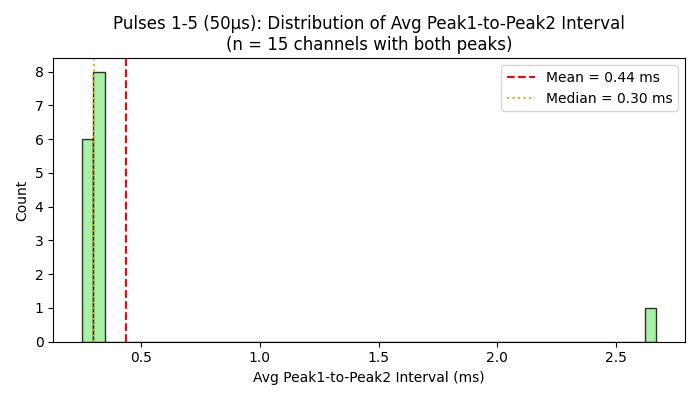

Pulses 1-5 (50µs):
  Channels with both peaks: 15
  Mean interval: 0.44 ms
  Median interval: 0.30 ms
  Std deviation: 0.60 ms
  Range: 0.25 - 2.67 ms



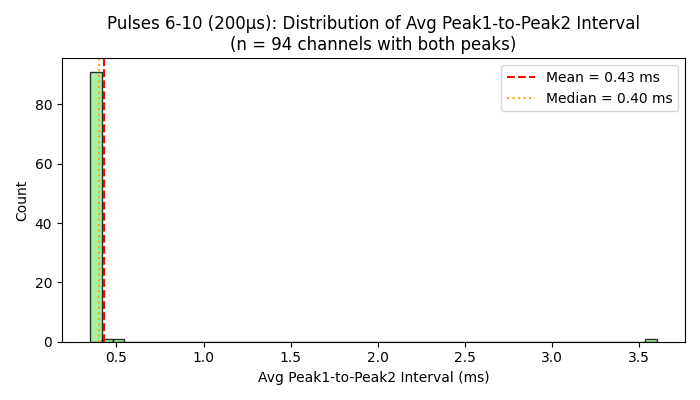

Pulses 6-10 (200µs):
  Channels with both peaks: 94
  Mean interval: 0.43 ms
  Median interval: 0.40 ms
  Std deviation: 0.33 ms
  Range: 0.35 - 3.60 ms



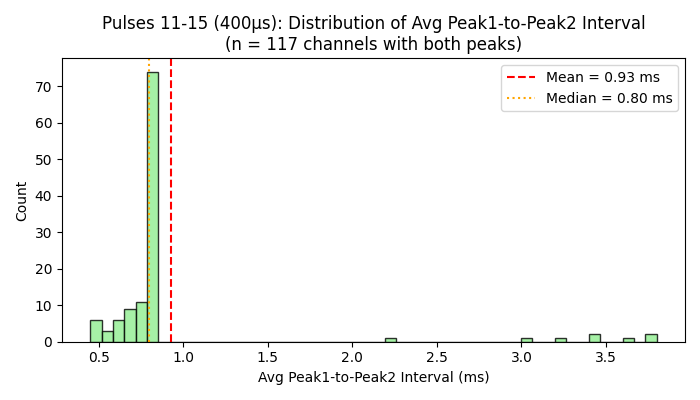

Pulses 11-15 (400µs):
  Channels with both peaks: 117
  Mean interval: 0.93 ms
  Median interval: 0.80 ms
  Std deviation: 0.66 ms
  Range: 0.45 - 3.80 ms



In [16]:
# Plot histogram (distribution) of average peak1-to-peak2 time interval for each group -LQRyan 2025-07-30

import matplotlib.pyplot as plt
import numpy as np


# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


for label, idxs in pulse_groupings.items():
    # Compute average peak1-to-peak2 interval for each channel
    intervals = []
    for n in idxs:
        peak1_times = plot_df[f'artifact{n:02d}_peak01_timestamp']
        peak2_times = plot_df[f'artifact{n:02d}_peak02_timestamp']
        
        # Calculate interval only for channels that have both peaks
        interval = peak2_times - peak1_times
        intervals.append(interval)
    
    # Stack intervals and compute average across pulses for each channel
    intervals_array = np.stack(intervals, axis=1)  # shape: (n_channels, n_pulses)
    avg_interval = np.nanmean(intervals_array, axis=1)  # average across pulses

    # Remove NaNs (channels without both peaks)
    valid_intervals = avg_interval[~np.isnan(avg_interval)]
    
    if len(valid_intervals) == 0:
        print(f"No valid peak1-to-peak2 intervals found for {label}")
        continue

    # Convert to milliseconds for easier interpretation
    valid_intervals_ms = valid_intervals * 1000

    # Plot histogram with more bins for finer resolution
    plt.figure(figsize=(7, 4))
    plt.hist(valid_intervals_ms, bins=50, color='lightgreen', edgecolor='k', alpha=0.8)
    plt.axvline(np.mean(valid_intervals_ms), color='red', linestyle='--', 
                label=f"Mean = {np.mean(valid_intervals_ms):.2f} ms")
    plt.axvline(np.median(valid_intervals_ms), color='orange', linestyle=':', 
                label=f"Median = {np.median(valid_intervals_ms):.2f} ms")
    plt.xlabel('Avg Peak1-to-Peak2 Interval (ms)')
    plt.ylabel('Count')
    plt.title(f'{label}: Distribution of Avg Peak1-to-Peak2 Interval\n(n = {len(valid_intervals)} channels with both peaks)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"{label}:")
    print(f"  Channels with both peaks: {len(valid_intervals)}")
    print(f"  Mean interval: {np.mean(valid_intervals_ms):.2f} ms")
    print(f"  Median interval: {np.median(valid_intervals_ms):.2f} ms")
    print(f"  Std deviation: {np.std(valid_intervals_ms):.2f} ms")
    print(f"  Range: {np.min(valid_intervals_ms):.2f} - {np.max(valid_intervals_ms):.2f} ms")
    print()

In [ ]:
"""PNG"""# Plot histogram (distribution) of average peak1-to-peak2 time interval for each group -LQRyan 2025-07-30
# Updated with PNG saving functionality

import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# Find the next available figure number with 3-digit format
existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
if existing_figures:
    # Extract numbers from existing figure names
    existing_numbers = []
    for fig_path in existing_figures:
        filename = os.path.basename(fig_path)
        try:
            # Extract number from "Figure_XXX.png" format (handles both 2 and 3 digit)
            number_str = filename.split('_')[1].split('.')[0]
            existing_numbers.append(int(number_str))
        except (IndexError, ValueError):
            continue
    
    # Start from the next available number
    figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
else:
    # No existing figures, start from 1
    figure_counter = 1

print(f"Output directory: {output_dir}")
print(f"Starting figure numbering from: Figure_{figure_counter:03d}")

print(f"Stim Channel = {stim_channel_id}")
# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


for label, idxs in pulse_groupings.items():
    # Compute average peak1-to-peak2 interval for each channel
    intervals = []
    for n in idxs:
        peak1_times = plot_df[f'artifact{n:02d}_peak01_timestamp']
        peak2_times = plot_df[f'artifact{n:02d}_peak02_timestamp']
        
        # Calculate interval only for channels that have both peaks
        interval = peak2_times - peak1_times
        intervals.append(interval)
    
    # Stack intervals and compute average across pulses for each channel
    intervals_array = np.stack(intervals, axis=1)  # shape: (n_channels, n_pulses)
    avg_interval = np.nanmean(intervals_array, axis=1)  # average across pulses

    # Remove NaNs (channels without both peaks)
    valid_intervals = avg_interval[~np.isnan(avg_interval)]
    
    if len(valid_intervals) == 0:
        print(f"No valid peak1-to-peak2 intervals found for {label}")
        continue

    # Convert to milliseconds for easier interpretation
    valid_intervals_ms = valid_intervals * 1000

    # Plot histogram with more bins for finer resolution
    plt.figure(figsize=(7, 4))
    plt.hist(valid_intervals_ms, bins=50, color='lightgreen', edgecolor='k', alpha=0.8)
    plt.axvline(np.mean(valid_intervals_ms), color='red', linestyle='--', 
                label=f"Mean = {np.mean(valid_intervals_ms):.2f} ms")
    plt.axvline(np.median(valid_intervals_ms), color='orange', linestyle=':', 
                label=f"Median = {np.median(valid_intervals_ms):.2f} ms")
    plt.xlabel('Avg Peak1-to-Peak2 Interval (ms)')
    plt.ylabel('Count')
    plt.title(f'{label}: Distribution of Avg Peak1-to-Peak2 Interval\n(n = {len(valid_intervals)} channels with both peaks)')
    plt.legend()
    plt.tight_layout()

    # Save figure as PNG with 3-digit numbering
    filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    # Show the plot
    plt.show()

    # Close figure to free memory
    plt.close()

    # Increment counter for next figure
    figure_counter += 1
    
    # Print summary statistics
    print(f"{label}:")
    print(f"  Channels with both peaks: {len(valid_intervals)}")
    print(f"  Mean interval: {np.mean(valid_intervals_ms):.2f} ms")
    print(f"  Median interval: {np.median(valid_intervals_ms):.2f} ms")
    print(f"  Std deviation: {np.std(valid_intervals_ms):.2f} ms")
    print(f"  Range: {np.min(valid_intervals_ms):.2f} - {np.max(valid_intervals_ms):.2f} ms")
    print()

print(f"\nAll histogram figures saved to: {os.path.abspath(output_dir)}")
print(f"Total figures saved: {figure_counter - (max(existing_numbers) + 1 if existing_figures else 1)}")
print(f"Figure numbering ended at: Figure_{figure_counter - 1:03d}")

In [ ]:
# Plot histogram (distribution) of average valley delay for each group LQRyan 2025-07-30

import matplotlib.pyplot as plt
import numpy as np

print(f"Stim Channel = {stim_channel_id}")
# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


for label, idxs in pulse_groupings.items():
    # Compute average valley delay for each channel (relative to stim channel)
    delays = []
    for n in idxs:
        # Get valley times for all channels
        valley_times_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        
        # Get valley time for stim channel for this pulse
        if stim_channel_id in wide_df['channel_id'].values:
            valley_time_stim = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            valley_time_stim = valley_time_stim[0] if len(valley_time_stim) > 0 else np.nan
        else:
            valley_time_stim = np.nan
        
        # Calculate delay relative to stim channel
        delay = valley_times_all - valley_time_stim
        delays.append(delay)
    
    # Stack delays and compute average across pulses for each channel
    delays_array = np.stack(delays, axis=1)  # shape: (n_channels, n_pulses)
    avg_delay = np.nanmean(delays_array, axis=1)  # average across pulses

    # Remove NaNs (channels without valid valley times)
    valid_delays = avg_delay[~np.isnan(avg_delay)]
    
    if len(valid_delays) == 0:
        print(f"No valid valley delays found for {label}")
        continue

    # Convert to milliseconds for easier interpretation
    valid_delays_ms = valid_delays * 1000

    # Plot histogram with more bins for finer resolution
    plt.figure(figsize=(7, 4))
    plt.hist(valid_delays_ms, bins=50, color='lightblue', edgecolor='k', alpha=0.8)
    plt.axvline(np.mean(valid_delays_ms), color='red', linestyle='--', 
                label=f"Mean = {np.mean(valid_delays_ms):.2f} ms")
    plt.axvline(np.median(valid_delays_ms), color='orange', linestyle=':', 
                label=f"Median = {np.median(valid_delays_ms):.2f} ms")
    plt.axvline(0, color='gray', linestyle='-', alpha=0.5, 
                label=f"Stim Ch {stim_channel_id}")
    plt.xlabel(f'Avg Valley Delay vs Ch {stim_channel_id} (ms)')
    plt.ylabel('Count')
    plt.title(f'{label}: Distribution of Avg Valley Delay\n(n = {len(valid_delays)} channels with valid valleys)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"{label}:")
    print(f"  Channels with valid valleys: {len(valid_delays)}")
    print(f"  Mean delay: {np.mean(valid_delays_ms):.2f} ms")
    print(f"  Median delay: {np.median(valid_delays_ms):.2f} ms")
    print(f"  Std deviation: {np.std(valid_delays_ms):.2f} ms")
    print(f"  Range: {np.min(valid_delays_ms):.2f} - {np.max(valid_delays_ms):.2f} ms")
    print()

In [ ]:
"""PNG"""# Plot histogram (distribution) of average valley delay for each group LQRyan 2025-07-30
# Updated with PNG saving functionality

import matplotlib.pyplot as plt
import numpy as np
import os
import glob


# Find the next available figure number with 3-digit format
existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
if existing_figures:
    # Extract numbers from existing figure names
    existing_numbers = []
    for fig_path in existing_figures:
        filename = os.path.basename(fig_path)
        try:
            # Extract number from "Figure_XXX.png" format (handles both 2 and 3 digit)
            number_str = filename.split('_')[1].split('.')[0]
            existing_numbers.append(int(number_str))
        except (IndexError, ValueError):
            continue
    
    # Start from the next available number
    figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
else:
    # No existing figures, start from 1
    figure_counter = 1

print(f"Output directory: {output_dir}")
print(f"Starting figure numbering from: Figure_{figure_counter:03d}")

# --- Exclude channels saved from the interactive selector ---
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


for label, idxs in pulse_groupings.items():
    # Compute average valley delay for each channel (relative to stim channel)
    delays = []
    for n in idxs:
        # Get valley times for all channels
        valley_times_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        
        # Get valley time for stim channel for this pulse
        if stim_channel_id in wide_df['channel_id'].values:
            valley_time_stim = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            valley_time_stim = valley_time_stim[0] if len(valley_time_stim) > 0 else np.nan
        else:
            valley_time_stim = np.nan
        
        # Calculate delay relative to stim channel
        delay = valley_times_all - valley_time_stim
        delays.append(delay)
    
    # Stack delays and compute average across pulses for each channel
    delays_array = np.stack(delays, axis=1)  # shape: (n_channels, n_pulses)
    avg_delay = np.nanmean(delays_array, axis=1)  # average across pulses

    # Remove NaNs (channels without valid valley times)
    valid_delays = avg_delay[~np.isnan(avg_delay)]
    
    if len(valid_delays) == 0:
        print(f"No valid valley delays found for {label}")
        continue

    # Convert to milliseconds for easier interpretation
    valid_delays_ms = valid_delays * 1000

    # Plot histogram with more bins for finer resolution
    plt.figure(figsize=(7, 4))
    plt.hist(valid_delays_ms, bins=50, color='lightblue', edgecolor='k', alpha=0.8)
    plt.axvline(np.mean(valid_delays_ms), color='red', linestyle='--', 
                label=f"Mean = {np.mean(valid_delays_ms):.2f} ms")
    plt.axvline(np.median(valid_delays_ms), color='orange', linestyle=':', 
                label=f"Median = {np.median(valid_delays_ms):.2f} ms")
    plt.axvline(0, color='gray', linestyle='-', alpha=0.5, 
                label=f"Stim Ch {stim_channel_id}")
    plt.xlabel(f'Avg Valley Delay vs Ch {stim_channel_id} (ms)')
    plt.ylabel('Count')
    plt.title(f'{label}: Distribution of Avg Valley Delay\n(n = {len(valid_delays)} channels with valid valleys)')
    plt.legend()
    plt.tight_layout()

    # Save figure as PNG with 3-digit numbering
    filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    # Show the plot
    plt.show()

    # Close figure to free memory
    plt.close()

    # Increment counter for next figure
    figure_counter += 1
    
    # Print summary statistics
    print(f"{label}:")
    print(f"  Channels with valid valleys: {len(valid_delays)}")
    print(f"  Mean delay: {np.mean(valid_delays_ms):.2f} ms")
    print(f"  Median delay: {np.median(valid_delays_ms):.2f} ms")
    print(f"  Std deviation: {np.std(valid_delays_ms):.2f} ms")
    print(f"  Range: {np.min(valid_delays_ms):.2f} - {np.max(valid_delays_ms):.2f} ms")
    print()

print(f"\nAll valley delay histogram figures saved to: {os.path.abspath(output_dir)}")
print(f"Total figures saved: {figure_counter - (max(existing_numbers) + 1 if existing_figures else 1)}")
print(f"Figure numbering ended at: Figure_{figure_counter - 1:03d}")

In [ ]:
# Peak 1 Amplitude vs Distance from Stim for four groups, excluding selected channels Mk03 - LQRyan 2025-07-30
import matplotlib.pyplot as plt
import numpy as np

# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Updated to match your current stim channel

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


plt.figure(figsize=(16, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Added 4th color

for i, (label, idxs) in enumerate(pulse_groupings.items()):
    cols = [f'artifact{n:02d}_peak01_µV' for n in idxs]
    avg_peak = plot_df[cols].mean(axis=1)
    plt.scatter(
        plot_df['distance_to_stim'],
        avg_peak,
        color=colors[i],
        label=label,
        alpha=0.7,
        s=15
    )

# --- Add enhanced title with chip info ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

plt.xlabel('Distance to Stim (μm)')
plt.ylabel('Average Peak 1 Amplitude (µV)')

# Enhanced title with chip information
title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
title += f'Average Peak 1 Amplitude vs. Distance from Stim\n'
title += f'File: {file_name} | Excluded Channels: {exclude_channels}'
plt.title(title)

# Set y-axis ticks with step of 50 and ensure 0 is included
y_min, y_max = plt.ylim()
# Round to nearest 50 and ensure 0 is included
y_min_rounded = int(np.floor(y_min / 50.0) * 50)
y_max_rounded = int(np.ceil(y_max / 50.0) * 50)
# Ensure 0 is included in the range
if y_min_rounded > 0:
    y_min_rounded = 0
if y_max_rounded < 0:
    y_max_rounded = 0
y_ticks = np.arange(y_min_rounded, y_max_rounded + 50, 50)
plt.yticks(y_ticks)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Peak 2 Amplitude vs Distance from Stim for four groups, excluding selected channels Mk03 - LQRyan 2025-07-30
import matplotlib.pyplot as plt
import numpy as np

# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Updated to match your current stim channel

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


plt.figure(figsize=(16, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Added 4th color

for i, (label, idxs) in enumerate(pulse_groupings.items()):
    cols = [f'artifact{n:02d}_peak02_µV' for n in idxs]
    avg_peak = plot_df[cols].mean(axis=1)
    plt.scatter(
        plot_df['distance_to_stim'],
        avg_peak,
        color=colors[i],
        label=label,
        alpha=0.7,
        s=15
    )

# --- Add enhanced title with chip info ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

plt.xlabel('Distance to Stim (μm)')
plt.ylabel('Average Peak 2 Amplitude (µV)')

# Enhanced title with chip information
title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
title += f'Average Peak 2 Amplitude vs. Distance from Stim\n'
title += f'File: {file_name} | Excluded Channels: {exclude_channels}'
plt.title(title)

# Set y-axis ticks with step of 50 and ensure 0 is included
y_min, y_max = plt.ylim()
# Round to nearest 50 and ensure 0 is included
y_min_rounded = int(np.floor(y_min / 50.0) * 50)
y_max_rounded = int(np.ceil(y_max / 50.0) * 50)
# Ensure 0 is included in the range
if y_min_rounded > 0:
    y_min_rounded = 0
if y_max_rounded < 0:
    y_max_rounded = 0
y_ticks = np.arange(y_min_rounded, y_max_rounded + 50, 50)
plt.yticks(y_ticks)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Peak Valley Amplitude vs Distance from Stim for three groups, excluding selected channels and channels with valley delay outside a specified range (in µV)
import matplotlib.pyplot as plt
import numpy as np


print(f"Stim Channel = {stim_channel_id}")
# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Updated to use current stim channel

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


# --- Exclude channels with valley delay outside the specified range in ANY pulse in the group ---
channels_to_keep = set(plot_df['channel_id'])
for idxs in pulse_groupings.values():
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays = t_all - t_ref
        bad_mask = (delays < min_delay) | (delays > max_delay)
        bad_channels = plot_df.loc[bad_mask, 'channel_id']
        channels_to_keep = channels_to_keep - set(bad_channels)

# Filter plot_df to only include channels within delay range for all pulses in all groups
plot_df = plot_df[plot_df['channel_id'].isin(channels_to_keep)]

plt.figure(figsize=(16, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Added 4th color

for i, (label, idxs) in enumerate(pulse_groupings.items()):
    cols = [f'artifact{n:02d}_valley_µV' for n in idxs]
    avg_valley = plot_df[cols].mean(axis=1)
    plt.scatter(
        plot_df['distance_to_stim'],
        avg_valley,  # µV, no conversion
        color=colors[i],
        label=label,
        alpha=0.7,
        s=15
    )

# --- Add file name ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

plt.xlabel('Distance to Stim (μm)')
plt.ylabel('Average Valley Amplitude (µV)')

# Enhanced title with chip information
title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
title += f'Average Valley Amplitude vs. Distance from Stim\n'
title += f'File: {file_name} | Excluded Channels: {exclude_channels}\n'
title += f'(Also, Channels with valley delay outside [{min_delay}, {max_delay}] s excluded)'
plt.title(title)

# Set y-axis ticks with step of 50 and ensure 0 is included
y_min, y_max = plt.ylim()
# Round to nearest 50 and ensure 0 is included
y_min_rounded = int(np.floor(y_min / 50.0) * 50)
y_max_rounded = int(np.ceil(y_max / 50.0) * 50)
# Ensure 0 is included in the range
if y_min_rounded > 0:
    y_min_rounded = 0
if y_max_rounded < 0:
    y_max_rounded = 0
y_ticks = np.arange(y_min_rounded, y_max_rounded + 50, 100)
plt.yticks(y_ticks)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot: Average valley delay vs distance from stim for four groups, excluding selected channels Mk03 - LQRyan 2025-07-30
import matplotlib.pyplot as plt
import numpy as np

print(f"Stim Channel = {stim_channel_id}")
# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Added 4th color
plt.figure(figsize=(16, 8))

for i, (label, idxs) in enumerate(pulse_groupings.items()):
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)
    plt.scatter(
        plot_df['distance_to_stim'],
        avg_delay,
        color=colors[i],
        label=label,
        alpha=0.7,
        s=15
    )

# --- Add enhanced title with chip info ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Distance to Stim (μm)')
plt.ylabel(f'Average Valley Delay vs Ch {stim_channel_id} (s)')

# Enhanced title with chip information
title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
title += f'Average Valley Delay vs. Distance from Stim\n'
title += f'File: {file_name} | Excluded Channels: {exclude_channels}'
plt.title(title)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Scatter plot: Average valley delay vs distance from stim for four groups, excluding selected channels Mk03 - LQRyan 2025-07-30
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


print(f"Stim Channel = {stim_channel_id}")
# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Added 4th color
plt.figure(figsize=(16, 8))

for i, (label, idxs) in enumerate(pulse_groupings.items()):
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)
    
    # Get distance and remove NaN values for regression
    distance = plot_df['distance_to_stim']
    mask = ~np.isnan(avg_delay) & ~np.isnan(distance)
    x_clean = distance[mask]
    y_clean = avg_delay[mask]
    
    # Plot scatter points
    plt.scatter(
        plot_df['distance_to_stim'],
        avg_delay,
        color=colors[i],
        label=label,
        alpha=0.7,
        s=15
    )
    
    # Add trendline if we have enough valid data points
    if len(x_clean) > 1:
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        
        # Create trendline
        x_trend = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_trend = slope * x_trend + intercept
        
        # Plot trendline
        plt.plot(x_trend, y_trend, 
                color=colors[i], 
                linestyle='--', 
                linewidth=2, 
                alpha=0.8,
                label=f'{label} trend (R²={r_value**2:.3f}, p={p_value:.3f})')

# --- Add enhanced title with chip info ---
file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Distance to Stim (μm)')
plt.ylabel(f'Average Valley Delay vs Ch {stim_channel_id} (s)')

# Enhanced title with chip information
title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
title += f'Average Valley Delay vs. Distance from Stim with Trendlines\n'
title += f'File: {file_name} | Excluded Channels: {exclude_channels}'
plt.title(title)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# One-sample t-test: Is the mean valley delay (vs stim channel) significantly different from zero? -20250730

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


for label, idxs in pulse_groupings.items():
    # Compute average delay for each channel
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)

    # Remove NaNs
    avg_delay = avg_delay[~np.isnan(avg_delay)]

    # One-sample t-test against 0 (null hypothesis: mean delay = 0)
    t_stat, p_val = stats.ttest_1samp(avg_delay, 0.0)
    mean_delay = np.mean(avg_delay)
    std_delay = np.std(avg_delay)

    print(f"{label}: mean delay = {mean_delay:.4g} s, std = {std_delay:.4g} s, t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}")

    # --- Enhanced title with chip info ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
    
    # Optional: plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(avg_delay, bins=20, color='skyblue', edgecolor='k', alpha=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=2, label=f'Null (delay=0)')
    plt.axvline(mean_delay, color='red', linestyle='-', linewidth=2, label=f'Mean = {mean_delay*1000:.2f} ms')
    
    # Enhanced title with chip information
    title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
    title += f'{label}: Valley Delay vs Ch {stim_channel_id}\n'
    title += f'One-sample t-test: t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}'
    plt.title(title)
    
    plt.xlabel("Average Valley Delay (s)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
"""PNG"""# One-sample t-test: Is the mean valley delay (vs stim channel) significantly different from zero? -20250730
# Updated with PNG saving functionality

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
import glob


# Find the next available figure number with 3-digit format
existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
if existing_figures:
    # Extract numbers from existing figure names
    existing_numbers = []
    for fig_path in existing_figures:
        filename = os.path.basename(fig_path)
        try:
            # Extract number from "Figure_XXX.png" format (handles both 2 and 3 digit)
            number_str = filename.split('_')[1].split('.')[0]
            existing_numbers.append(int(number_str))
        except (IndexError, ValueError):
            continue
    
    # Start from the next available number
    figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
else:
    # No existing figures, start from 1
    figure_counter = 1

print(f"Output directory: {output_dir}")
print(f"Starting figure numbering from: Figure_{figure_counter:03d}")
print(f"Stim Channel = {stim_channel_id}")

# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]

for label, idxs in pulse_groupings.items():
    # Compute average delay for each channel
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)

    # Remove NaNs
    avg_delay = avg_delay[~np.isnan(avg_delay)]

    # One-sample t-test against 0 (null hypothesis: mean delay = 0)
    t_stat, p_val = stats.ttest_1samp(avg_delay, 0.0)
    mean_delay = np.mean(avg_delay)
    std_delay = np.std(avg_delay)

    print(f"{label}: mean delay = {mean_delay:.4g} s, std = {std_delay:.4g} s, t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}")

    # --- Enhanced title with chip info ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"
    
    # Create histogram plot
    plt.figure(figsize=(8, 5))
    plt.hist(avg_delay, bins=20, color='skyblue', edgecolor='k', alpha=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=2, label=f'Null (delay=0)')
    plt.axvline(mean_delay, color='red', linestyle='-', linewidth=2, label=f'Mean = {mean_delay*1000:.2f} ms')
    
    # Enhanced title with chip information
    title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
    title += f'{label}: Valley Delay vs Ch {stim_channel_id}\n'
    title += f'One-sample t-test: t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}'
    plt.title(title)
    
    plt.xlabel("Average Valley Delay (s)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figure as PNG with 3-digit numbering
    filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    # Show the plot
    plt.show()

    # Close figure to free memory
    plt.close()

    # Increment counter for next figure
    figure_counter += 1

print(f"\nAll t-test figures saved to: {os.path.abspath(output_dir)}")
print(f"Total figures saved: {figure_counter - (max(existing_numbers) + 1 if existing_figures else 1)}")
print(f"Figure numbering ended at: Figure_{figure_counter - 1:03d}")

In [ ]:
# One-sample t-test: Is the mean delay to Peak 1 or Peak 2 (vs stim channel 105) significantly different from zero? (four groups) -20250730

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

print(f"Stim Channel = {stim_channel_id}")
# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


for peak in ['peak01', 'peak02']:
    print(f"\n--- One-sample t-test for {peak} delay (vs ch {stim_channel_id}) ---")
    for label, idxs in pulse_groupings.items():
        # Compute average delay for each channel
        delays = []
        for n in idxs:
            t_all = plot_df[f'artifact{n:02d}_{peak}_timestamp']
            if stim_channel_id in wide_df['channel_id'].values:
                t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_{peak}_timestamp'].values
                t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
            else:
                t_ref = np.nan
            delays.append(t_all - t_ref)
        avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)

        # Remove NaNs
        avg_delay = avg_delay[~np.isnan(avg_delay)]

        # One-sample t-test against 0 (null hypothesis: mean delay = 0)
        t_stat, p_val = stats.ttest_1samp(avg_delay, 0.0)
        mean_delay = np.mean(avg_delay)
        std_delay = np.std(avg_delay)

        print(f"{label}: mean delay = {mean_delay:.4g} s, std = {std_delay:.4g} s, t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}")

        # --- Enhanced title with chip info ---
        file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

        # Optional: plot histogram
        plt.figure(figsize=(8, 5))
        plt.hist(avg_delay, bins=20, color='skyblue', edgecolor='k', alpha=0.7)
        plt.axvline(0, color='gray', linestyle='--', linewidth=2, label=f'Null (delay=0)')
        plt.axvline(mean_delay, color='red', linestyle='-', linewidth=2, label=f'Mean = {mean_delay*1000:.2f} ms')
        
        # Enhanced title with chip information
        title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
        title += f'{label}: {peak.replace("peak", "Peak ").replace("01", "1").replace("02", "2")} Delay vs Ch {stim_channel_id}\n'
        title += f'One-sample t-test: t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}'
        plt.title(title)
        
        plt.xlabel("Average Delay (s)")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [ ]:
"""PNG"""# One-sample t-test: Is the mean delay to Peak 1 or Peak 2 (vs stim channel 105) significantly different from zero? (four groups) -20250730
# Updated with PNG saving functionality

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
import glob


# Find the next available figure number with 3-digit format
existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
if existing_figures:
    # Extract numbers from existing figure names
    existing_numbers = []
    for fig_path in existing_figures:
        filename = os.path.basename(fig_path)
        try:
            # Extract number from "Figure_XXX.png" format (handles both 2 and 3 digit)
            number_str = filename.split('_')[1].split('.')[0]
            existing_numbers.append(int(number_str))
        except (IndexError, ValueError):
            continue
    
    # Start from the next available number
    figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
else:
    # No existing figures, start from 1
    figure_counter = 1

print(f"Output directory: {output_dir}")
print(f"Starting figure numbering from: Figure_{figure_counter:03d}")

# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]

for peak in ['peak01', 'peak02']:
    print(f"\n--- One-sample t-test for {peak} delay (vs ch {stim_channel_id}) ---")
    for label, idxs in pulse_groupings.items():
        # Compute average delay for each channel
        delays = []
        for n in idxs:
            t_all = plot_df[f'artifact{n:02d}_{peak}_timestamp']
            if stim_channel_id in wide_df['channel_id'].values:
                t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_{peak}_timestamp'].values
                t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
            else:
                t_ref = np.nan
            delays.append(t_all - t_ref)
        avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)

        # Remove NaNs
        avg_delay = avg_delay[~np.isnan(avg_delay)]

        # One-sample t-test against 0 (null hypothesis: mean delay = 0)
        t_stat, p_val = stats.ttest_1samp(avg_delay, 0.0)
        mean_delay = np.mean(avg_delay)
        std_delay = np.std(avg_delay)

        print(f"{label}: mean delay = {mean_delay:.4g} s, std = {std_delay:.4g} s, t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}")

        # --- Enhanced title with chip info ---
        file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

        # Create histogram plot
        plt.figure(figsize=(8, 5))
        plt.hist(avg_delay, bins=20, color='skyblue', edgecolor='k', alpha=0.7)
        plt.axvline(0, color='gray', linestyle='--', linewidth=2, label=f'Null (delay=0)')
        plt.axvline(mean_delay, color='red', linestyle='-', linewidth=2, label=f'Mean = {mean_delay*1000:.2f} ms')
        
        # Enhanced title with chip information
        title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
        title += f'{label}: {peak.replace("peak", "Peak ").replace("01", "1").replace("02", "2")} Delay vs Ch {stim_channel_id}\n'
        title += f'One-sample t-test: t = {t_stat:.3g}, p = {p_val:.3g}, n = {len(avg_delay)}'
        plt.title(title)
        
        plt.xlabel("Average Delay (s)")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Save figure as PNG with 3-digit numbering
        filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")

        # Show the plot
        plt.show()

        # Close figure to free memory
        plt.close()

        # Increment counter for next figure
        figure_counter += 1

print(f"\nAll peak delay t-test figures saved to: {os.path.abspath(output_dir)}")
print(f"Total figures saved: {figure_counter - (max(existing_numbers) + 1 if existing_figures else 1)}")
print(f"Figure numbering ended at: Figure_{figure_counter - 1:03d}")

In [ ]:
# Statistical analysis: Is there a significant (non-random) relationship between valley delay and distance? (scipy version) 20250730

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]


results = {}
for label, idxs in pulse_groupings.items():
    # Compute average delay for each channel
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)
    distance = plot_df['distance_to_stim'].values

    # Remove NaNs for regression
    mask = ~np.isnan(avg_delay) & ~np.isnan(distance)
    X = distance[mask]
    y = avg_delay[mask]

    # Check if we have enough valid data points
    if len(X) < 2:
        print(f"⚠️  {label}: Insufficient data for regression (n={len(X)}). Skipping...")
        results[label] = {
            'slope': np.nan,
            'pval': np.nan,
            'r2': np.nan,
            'n': len(X)
        }
        continue

    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

    results[label] = {
        'slope': slope,
        'pval': p_value,
        'r2': r_value**2,
        'n': len(y)
    }

    # --- Add file name to the title ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

    # Plot with regression line
    plt.figure(figsize=(7, 5))
    plt.scatter(X, y, s=15, alpha=0.7, label='Channels')
    plt.plot(np.sort(X), intercept + slope * np.sort(X), color='red', lw=2, label='Fit')
    plt.axhline(0, color='gray', linestyle='--', lw=1)
    plt.xlabel('Distance to Stim (μm)')
    plt.ylabel(f'Avg Valley Delay vs Ch {stim_channel_id} (s)')
    plt.title(f'{label}: Valley Delay vs Distance\nSlope={slope:.4g}, p={p_value:.3g}, R²={r_value**2:.3g}, n={len(y)}\nFile: {file_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Print summary
print("\n" + "="*50)
print("REGRESSION ANALYSIS SUMMARY - VALLEY DELAY:")
print(f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV')
print("="*50)
for label, res in results.items():
    if np.isnan(res['slope']):
        print(f"{label}: Insufficient data (n={res['n']})")
    else:
        significance = "***" if res['pval'] < 0.001 else "**" if res['pval'] < 0.01 else "*" if res['pval'] < 0.05 else ""
        print(f"{label}: slope={res['slope']:.4g}, p={res['pval']:.3g}{significance}, R²={res['r2']:.3g}, n={res['n']}")
print("="*50)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")

In [ ]:
"""PNG"""# Statistical analysis: Is there a significant (non-random) relationship between valley delay and distance? (scipy version) 20250730
# Updated with PNG saving functionality

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import os
import glob


# Find the next available figure number with 3-digit format
existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
if existing_figures:
    # Extract numbers from existing figure names
    existing_numbers = []
    for fig_path in existing_figures:
        filename = os.path.basename(fig_path)
        try:
            # Extract number from "Figure_XXX.png" format (handles both 2 and 3 digit)
            number_str = filename.split('_')[1].split('.')[0]
            existing_numbers.append(int(number_str))
        except (IndexError, ValueError):
            continue
    
    # Start from the next available number
    figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
else:
    # No existing figures, start from 1
    figure_counter = 1

print(f"Output directory: {output_dir}")
print(f"Starting figure numbering from: Figure_{figure_counter:03d}")


# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]

results = {}
for label, idxs in pulse_groupings.items():
    # Compute average delay for each channel
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_valley_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_valley_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)
    distance = plot_df['distance_to_stim'].values

    # Remove NaNs for regression
    mask = ~np.isnan(avg_delay) & ~np.isnan(distance)
    X = distance[mask]
    y = avg_delay[mask]

    # Check if we have enough valid data points
    if len(X) < 2:
        print(f"⚠️  {label}: Insufficient data for regression (n={len(X)}). Skipping...")
        results[label] = {
            'slope': np.nan,
            'pval': np.nan,
            'r2': np.nan,
            'n': len(X)
        }
        continue

    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

    results[label] = {
        'slope': slope,
        'pval': p_value,
        'r2': r_value**2,
        'n': len(y)
    }

    # --- Enhanced title with chip info ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

    # Plot with regression line
    plt.figure(figsize=(7, 5))
    plt.scatter(X, y, s=15, alpha=0.7, label='Channels')
    plt.plot(np.sort(X), intercept + slope * np.sort(X), color='red', lw=2, label='Fit')
    plt.axhline(0, color='gray', linestyle='--', lw=1)
    plt.xlabel('Distance to Stim (μm)')
    plt.ylabel(f'Avg Valley Delay vs Ch {stim_channel_id} (s)')
    
    # Enhanced title with chip information
    title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
    title += f'{label}: Valley Delay vs Distance\n'
    title += f'Slope={slope:.4g}, p={p_value:.3g}, R²={r_value**2:.3g}, n={len(y)}'
    plt.title(title)
    
    plt.legend()
    plt.tight_layout()
    
    # Save figure as PNG with 3-digit numbering
    filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    # Show the plot
    plt.show()

    # Close figure to free memory
    plt.close()

    # Increment counter for next figure
    figure_counter += 1

# Print summary
print("\n" + "="*50)
print("REGRESSION ANALYSIS SUMMARY - VALLEY DELAY:")
print(f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV')
print("="*50)
for label, res in results.items():
    if np.isnan(res['slope']):
        print(f"{label}: Insufficient data (n={res['n']})")
    else:
        significance = "***" if res['pval'] < 0.001 else "**" if res['pval'] < 0.01 else "*" if res['pval'] < 0.05 else ""
        print(f"{label}: slope={res['slope']:.4g}, p={res['pval']:.3g}{significance}, R²={res['r2']:.3g}, n={res['n']}")
print("="*50)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")

print(f"\nAll valley delay regression figures saved to: {os.path.abspath(output_dir)}")
print(f"Total figures saved: {figure_counter - (max(existing_numbers) + 1 if existing_figures else 1)}")
print(f"Figure numbering ended at: Figure_{figure_counter - 1:03d}")

In [ ]:
# Statistical analysis: Is there a significant (non-random) relationship between Peak 2 delay and distance? (scipy version) 20250730

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]

results = {}
for label, idxs in pulse_groupings.items():
    # Compute average Peak 2 delay for each channel
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_peak02_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_peak02_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)
    distance = plot_df['distance_to_stim'].values

    # Remove NaNs for regression
    mask = ~np.isnan(avg_delay) & ~np.isnan(distance)
    X = distance[mask]
    y = avg_delay[mask]

    # Check if we have enough valid data points
    if len(X) < 2:
        print(f"⚠️  {label}: Insufficient data for regression (n={len(X)}). Skipping...")
        results[label] = {
            'slope': np.nan,
            'pval': np.nan,
            'r2': np.nan,
            'n': len(X)
        }
        continue

    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

    results[label] = {
        'slope': slope,
        'pval': p_value,
        'r2': r_value**2,
        'n': len(y)
    }

    # --- Add file name to the title ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

    # Plot with regression line
    plt.figure(figsize=(7, 5))
    plt.scatter(X, y, s=15, alpha=0.7, label='Channels')
    plt.plot(np.sort(X), intercept + slope * np.sort(X), color='red', lw=2, label='Fit')
    plt.axhline(0, color='gray', linestyle='--', lw=1)
    plt.xlabel('Distance to Stim (μm)')
    plt.ylabel(f'Avg Peak 2 Delay vs Ch {stim_channel_id} (s)')
    plt.title(f'{label}: Peak 2 Delay vs Distance\nSlope={slope:.4g}, p={p_value:.3g}, R²={r_value**2:.3g}, n={len(y)}\nFile: {file_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Print summary
print("\n" + "="*50)
print("REGRESSION ANALYSIS SUMMARY - PEAK2 DELAY:")
print(f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV')
print("="*50)
for label, res in results.items():
    if np.isnan(res['slope']):
        print(f"{label}: Insufficient data (n={res['n']})")
    else:
        significance = "***" if res['pval'] < 0.001 else "**" if res['pval'] < 0.01 else "*" if res['pval'] < 0.05 else ""
        print(f"{label}: slope={res['slope']:.4g}, p={res['pval']:.3g}{significance}, R²={res['r2']:.3g}, n={res['n']}")
print("="*50)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")

In [ ]:
"""PNG"""# Statistical analysis: Is there a significant (non-random) relationship between Peak 2 delay and distance? (scipy version) 20250730
# Updated with PNG saving functionality and NaN handling - LQRyan 2025-08-01

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import os
import glob

# Find the next available figure number with 3-digit format
existing_figures = glob.glob(os.path.join(output_dir, "Figure_*.png"))
if existing_figures:
    # Extract numbers from existing figure names
    existing_numbers = []
    for fig_path in existing_figures:
        filename = os.path.basename(fig_path)
        try:
            # Extract number from "Figure_XXX.png" format (handles both 2 and 3 digit)
            number_str = filename.split('_')[1].split('.')[0]
            existing_numbers.append(int(number_str))
        except (IndexError, ValueError):
            continue
    
    # Start from the next available number
    figure_counter = max(existing_numbers) + 1 if existing_numbers else 1
else:
    # No existing figures, start from 1
    figure_counter = 1

print(f"Output directory: {output_dir}")
print(f"Starting figure numbering from: Figure_{figure_counter:03d}")


# Exclude channels if needed
exclude_path = "selected_channels.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r") as f:
        exclude_channels = [line.strip() for line in f.readlines()]
else:
    exclude_channels = [stim_channel_id]  # Exclude stim channel by default

plot_df = wide_df[~wide_df['channel_id'].isin(exclude_channels)]

results = {}
for label, idxs in pulse_groupings.items():
    # Compute average Peak 2 delay for each channel
    delays = []
    for n in idxs:
        t_all = plot_df[f'artifact{n:02d}_peak02_timestamp']
        if stim_channel_id in wide_df['channel_id'].values:
            t_ref = wide_df.loc[wide_df['channel_id'] == stim_channel_id, f'artifact{n:02d}_peak02_timestamp'].values
            t_ref = t_ref[0] if len(t_ref) > 0 else np.nan
        else:
            t_ref = np.nan
        delays.append(t_all - t_ref)
    avg_delay = np.nanmean(np.stack(delays, axis=1), axis=1)
    distance = plot_df['distance_to_stim'].values

    # Remove NaNs for regression
    mask = ~np.isnan(avg_delay) & ~np.isnan(distance)
    X = distance[mask]
    y = avg_delay[mask]

    # Check if we have enough valid data points
    if len(X) < 2:
        print(f"⚠️  {label}: Insufficient data for regression (n={len(X)}). Skipping...")
        results[label] = {
            'slope': np.nan,
            'pval': np.nan,
            'r2': np.nan,
            'n': len(X)
        }
        continue

    # Check if all x-values are identical (no variance)
    if len(np.unique(X)) == 1:
        print(f"⚠️  {label}: All channels equidistant from stimulation (distance={X[0]:.1f}μm). Cannot calculate regression.")
        results[label] = {
            'slope': np.nan,
            'pval': np.nan,
            'r2': np.nan,
            'n': len(X),
            'constant_distance': X[0]
        }
        
        # Create a scatter plot without regression line
        plt.figure(figsize=(7, 5))
        # Fix: Use X instead of [X[0]] to match the size of y
        plt.scatter(X, y, s=15, alpha=0.7, label='Channels')
        plt.axhline(np.mean(y), color='red', linestyle='--', lw=2, label=f'Mean delay: {np.mean(y):.4g}s')
        plt.axhline(0, color='gray', linestyle='--', lw=1)
        plt.xlabel('Distance to Stim (μm)')
        plt.ylabel(f'Avg Peak 2 Delay vs Ch {stim_channel_id} (s)')
        
        # Enhanced title
        title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
        title += f'{label}: Peak 2 Delay (Constant Distance)\n'
        title += f'All channels at {X[0]:.1f}μm, Mean delay={np.mean(y):.4g}s, n={len(y)}'
        plt.title(title)
        
        plt.legend()
        plt.tight_layout()
        
        # Save figure
        filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
        plt.show()
        plt.close()
        figure_counter += 1
        continue

    # Linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

    results[label] = {
        'slope': slope,
        'pval': p_value,
        'r2': r_value**2,
        'n': len(y)
    }

    # --- Enhanced title with chip info ---
    file_name = os.path.basename(local_path) if 'local_path' in globals() else "Unknown file"

    # Plot with regression line
    plt.figure(figsize=(7, 5))
    plt.scatter(X, y, s=15, alpha=0.7, label='Channels')
    plt.plot(np.sort(X), intercept + slope * np.sort(X), color='red', lw=2, label='Fit')
    plt.axhline(0, color='gray', linestyle='--', lw=1)
    plt.xlabel('Distance to Stim (μm)')
    plt.ylabel(f'Avg Peak 2 Delay vs Ch {stim_channel_id} (s)')
    
    # Enhanced title with chip information
    title = f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV\n'
    title += f'{label}: Peak 2 Delay vs Distance\n'
    title += f'Slope={slope:.4g}, p={p_value:.3g}, R²={r_value**2:.3g}, n={len(y)}'
    plt.title(title)
    
    plt.legend()
    plt.tight_layout()
    
    # Save figure as PNG with 3-digit numbering
    filename = os.path.join(output_dir, f"Figure_{figure_counter:03d}.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    # Show the plot
    plt.show()

    # Close figure to free memory
    plt.close()

    # Increment counter for next figure
    figure_counter += 1

# Print summary
print("\n" + "="*50)
print("REGRESSION ANALYSIS SUMMARY - PEAK2 DELAY:")
print(f'{chip_type} Chip {chip_id} | {test_number} @ {voltage}mV')
print("="*50)
for label, res in results.items():
    if np.isnan(res['slope']):
        if 'constant_distance' in res:
            print(f"{label}: All channels equidistant ({res['constant_distance']:.1f}μm) - no regression possible (n={res['n']})")
        else:
            print(f"{label}: Insufficient data (n={res['n']})")
    else:
        significance = "***" if res['pval'] < 0.001 else "**" if res['pval'] < 0.01 else "*" if res['pval'] < 0.05 else ""
        print(f"{label}: slope={res['slope']:.4g}, p={res['pval']:.3g}{significance}, R²={res['r2']:.3g}, n={res['n']}")
print("="*50)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")

print(f"\nAll Peak 2 delay regression figures saved to: {os.path.abspath(output_dir)}")
print(f"Total figures saved: {figure_counter - (max(existing_numbers) + 1 if existing_figures else 1)}")
print(f"Figure numbering ended at: Figure_{figure_counter - 1:03d}")

In [ ]:
## Debugging
artifact_df.info()

# ## Debugging
# print (artifact_df)

#Debug - checking the dataframe structure to ensure it has the expected columns - LQRyan 2025-06-20
# channel_df.info()

#Debug - checking dtype of channel_ids - LQRyan 2025-06-20
# type(channel_ids)

## Set the option to display all rows for channel_df ## good for mapping channels visually on a graph in excel
# pd.set_option('display.max_rows', None)
# display(channel_df)


# not sure wether this worked previously or not, looks like it was used to import the detect peaks function - LQRyan 2025-06-20
# import sys 
# sys.path.append(local_path)
# from helper_functions import detect_peaks

In [ ]:
# Debug - checking the values of a specific channel in the DataFrame to make sure x and y coordinates are correct - LQRyan 2025-06-20
# channel_id = '102'
channel_id = '149'
coords = channel_df[channel_df['channel_id'] == channel_id][['x', 'y']].values[0]
print(f"Coordinates for channel {channel_id}: {coords}")